In [1]:
import pandas as pd
import numpy as np
import torch 
%matplotlib inline
import math
import scipy.stats
import time
from sklearn.metrics import mean_squared_error,mean_absolute_error
import torch.utils.data as Data
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
import matplotlib.pyplot as plt

In [2]:
class Timer:  #@save
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()
    def start(self):
        """启动计时器"""
        self.tik = time.time()
    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]
    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)
    def sum(self):
        """返回时间总和"""
        return sum(self.times)
    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()

In [6]:
train=pd.read_feather('J:/quant_trade/database/trains.feather')
test=pd.read_feather('J:/quant_trade/database/tests.feather')
tlist=train.columns.tolist()
tlist=tlist[3:103]

In [11]:
x_train=train[tlist]
y_train=train['1W']
x_test=test[tlist]
y_test=test['1W']

In [12]:
train_xt=torch.from_numpy(x_train.values.astype(np.float32)).cuda()
train_yt=torch.from_numpy(y_train.values.astype(np.float32)).cuda()
test_xt=torch.from_numpy(x_test.values.astype(np.float32)).cuda()
test_yt=torch.from_numpy(y_test.values.astype(np.float32)).cpu()

In [13]:
train=None
test=None
x_train=None
y_train=None
x_test=None
y_test=None

In [16]:
train_data=Data.TensorDataset(train_xt,train_yt)
test_data=Data.TensorDataset(test_xt,test_yt)

In [17]:
class MLPrg(nn.Module):
    def __init__(self):
        super(MLPrg,self).__init__()
        self.hidden1=nn.Linear(in_features=100,out_features=512,bias=True)
        self.hidden2=nn.Linear(in_features=512,out_features=256)
        self.hidden3=nn.Linear(in_features=256,out_features=64)
        self.predict=nn.Linear(64,1)
        self.drop=nn.Dropout(0.2)
    def forward(self,x):
        x=F.tanh(self.hidden1(x))
        x=self.drop(x)
        x=F.tanh(self.hidden2(x))
        x=self.drop(x)
        x=F.tanh(self.hidden3(x))
        x=self.drop(x)
        output=self.predict(x)
        return output[:,0]
rg=MLPrg()
rg=rg.cuda()
loss_func=nn.MSELoss()
loss_func=loss_func.cuda()
train_loss_all=[]
maslist=[]
plt.figure(figsize=(10,6))

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [18]:
train_loader=Data.DataLoader(dataset=train_data,batch_size=512,shuffle=True,num_workers=0)
for step,(b_x,b_y) in enumerate(train_loader):
    if step>0:
        break

In [19]:
optimizer=torch.optim.Adam(rg.parameters(),lr=1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

In [20]:
info=[]

0


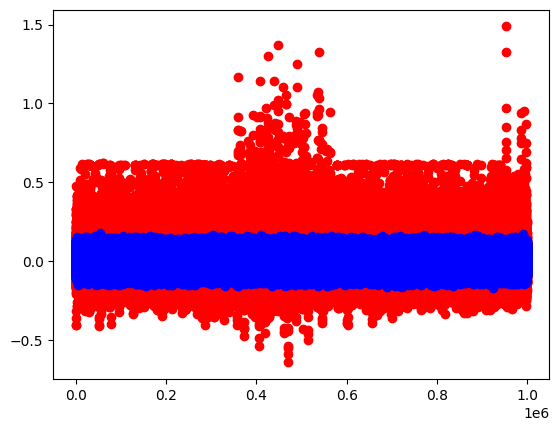

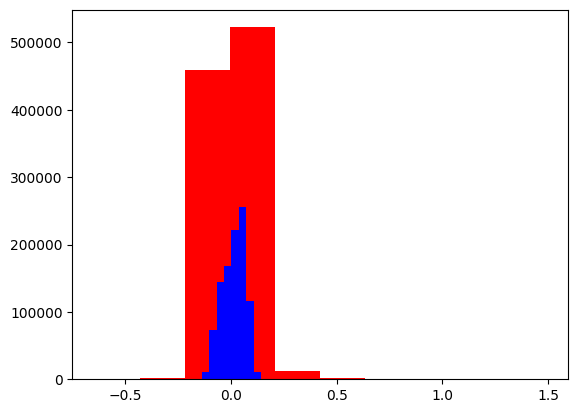

1


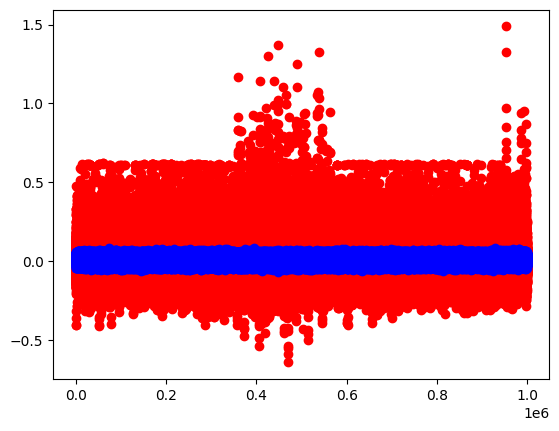

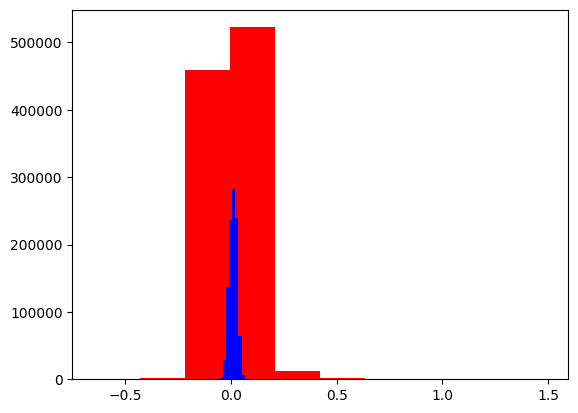

2


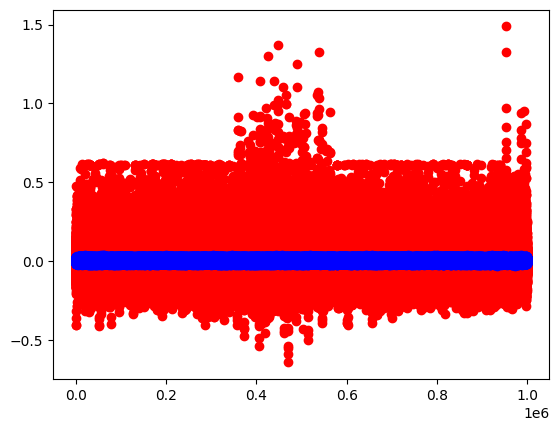

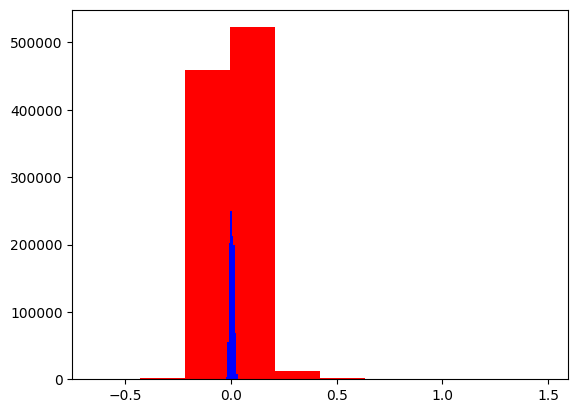

3


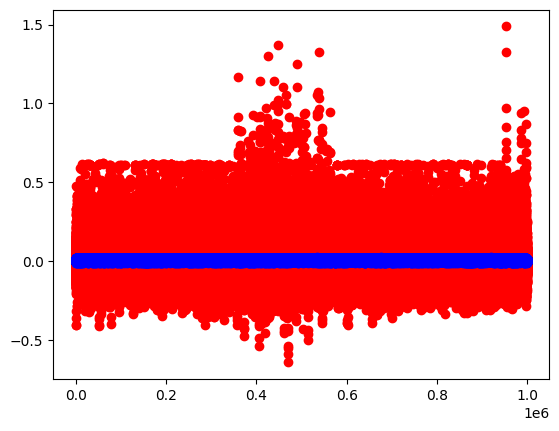

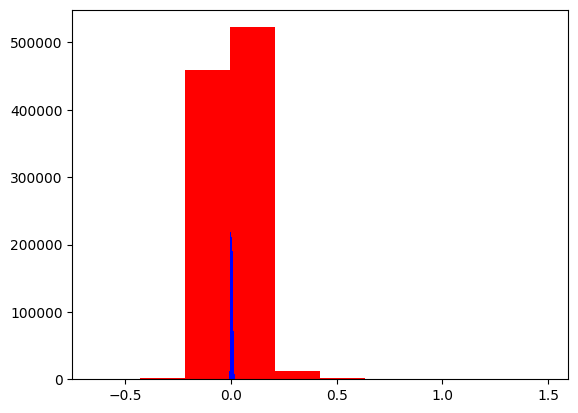

4


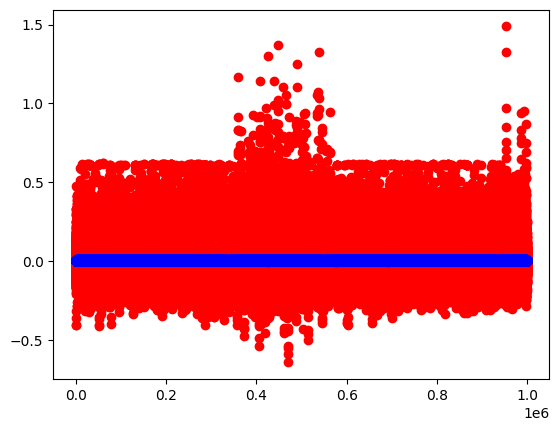

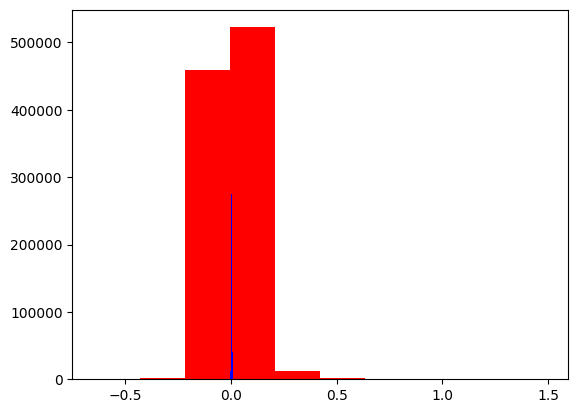

5


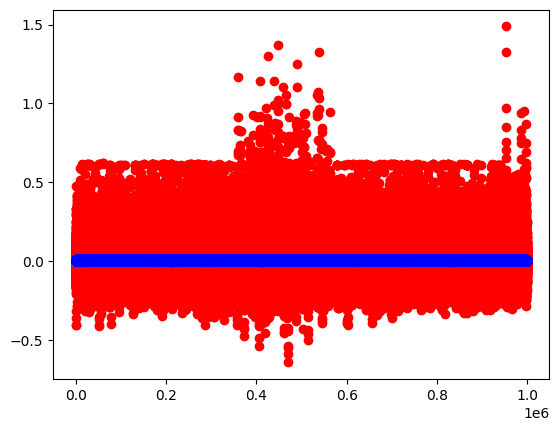

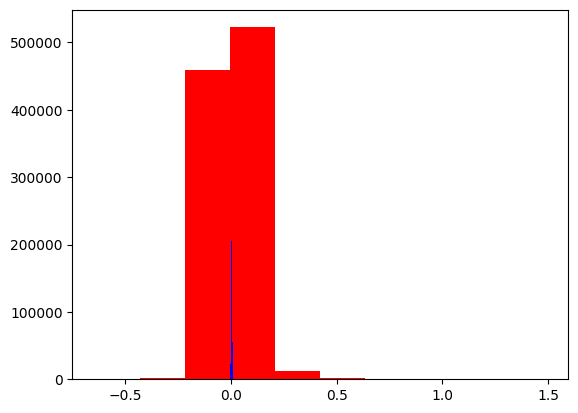

6


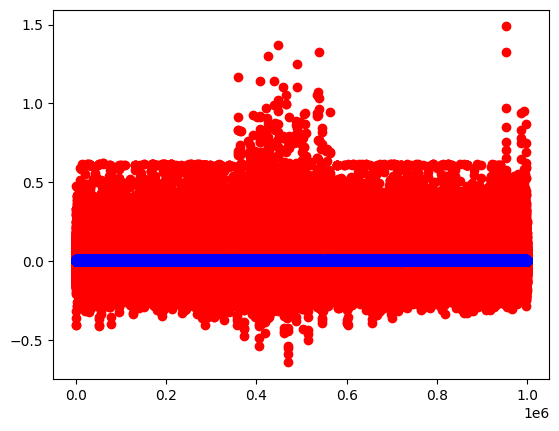

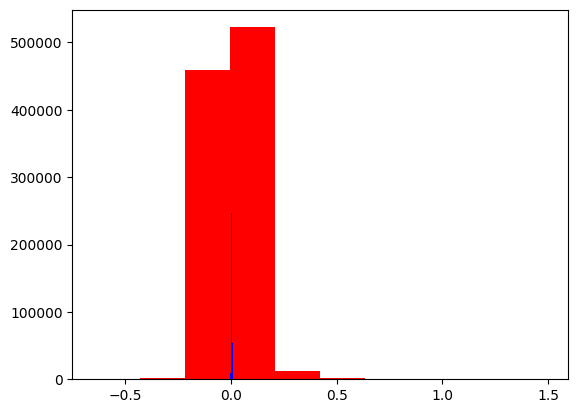

7


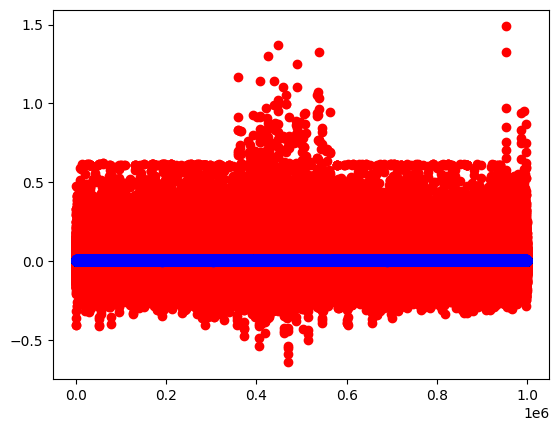

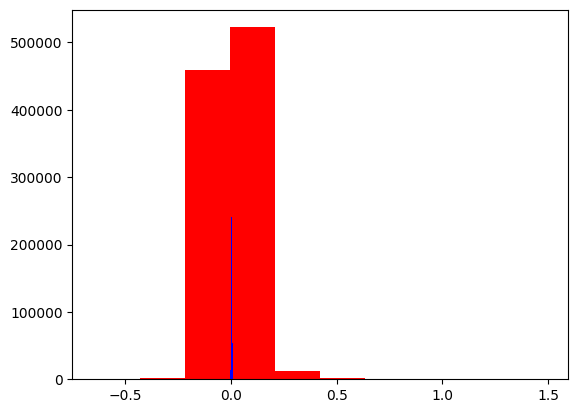

8


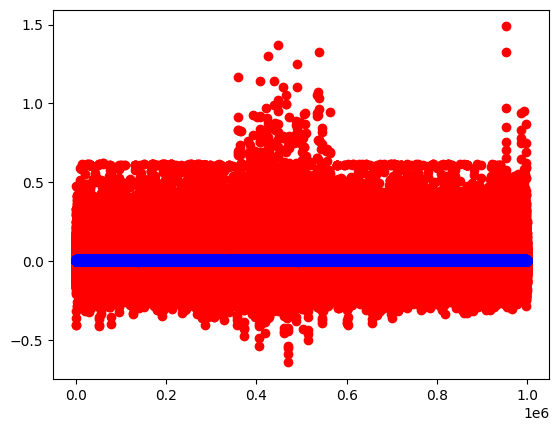

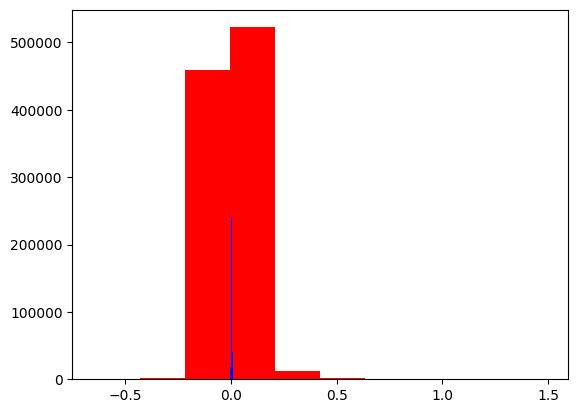

9


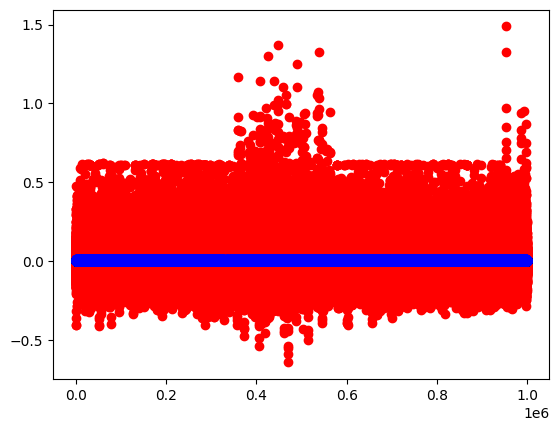

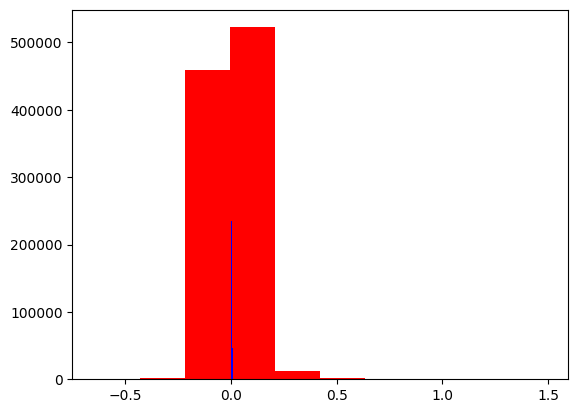

10


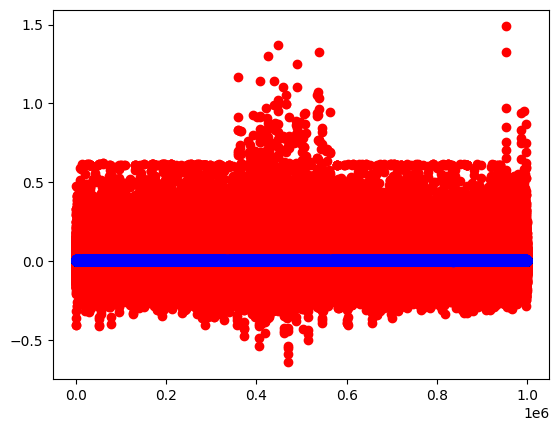

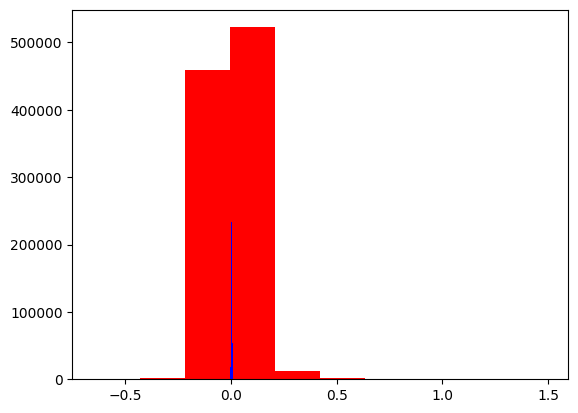

11


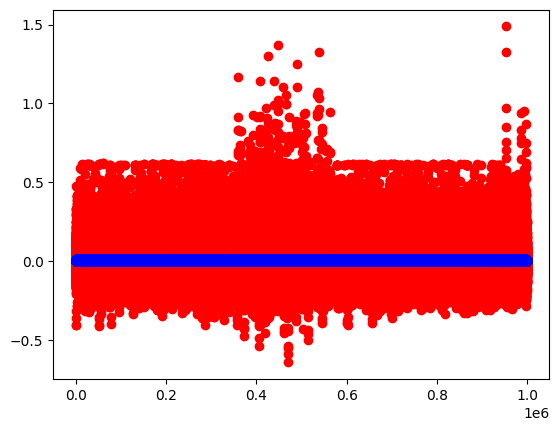

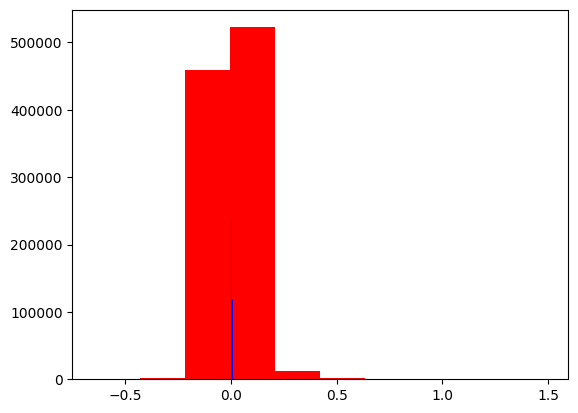

12


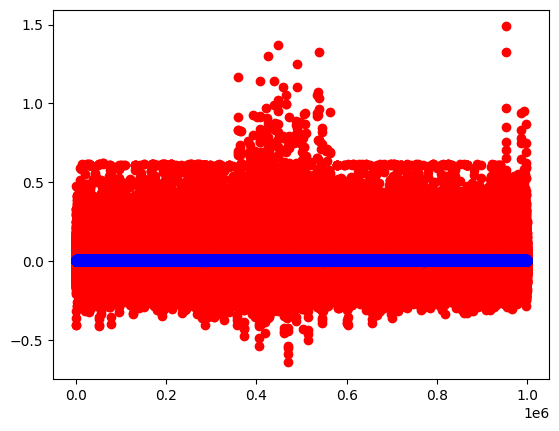

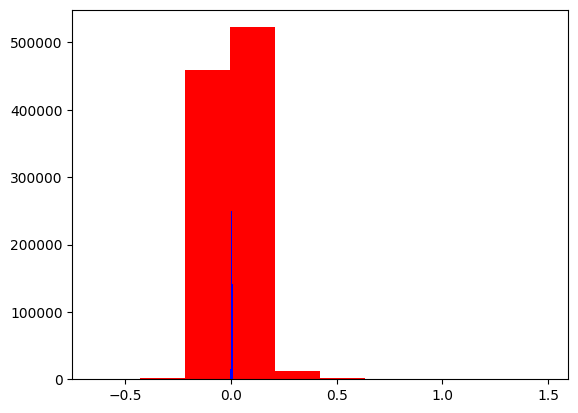

13


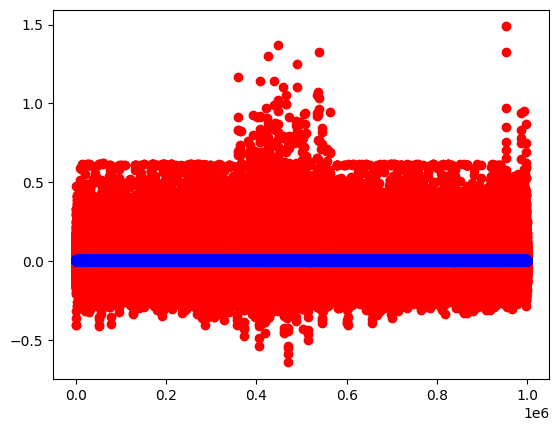

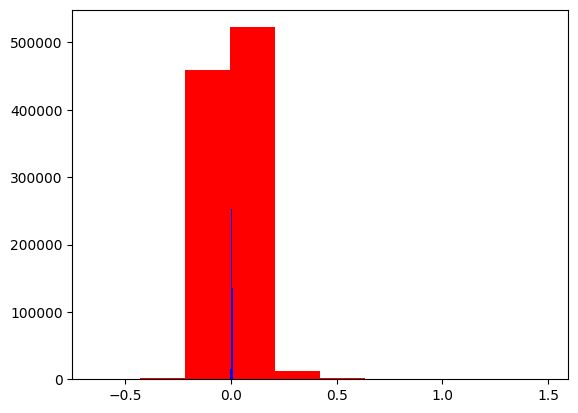

14


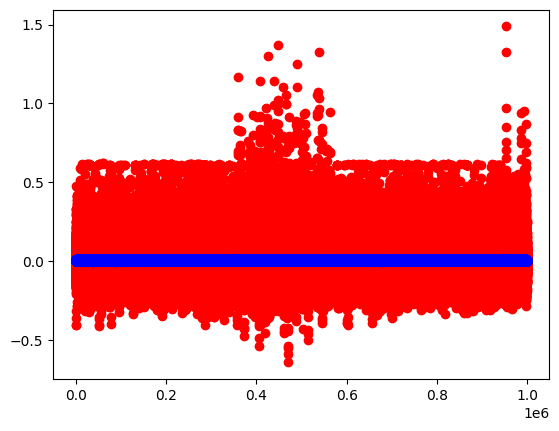

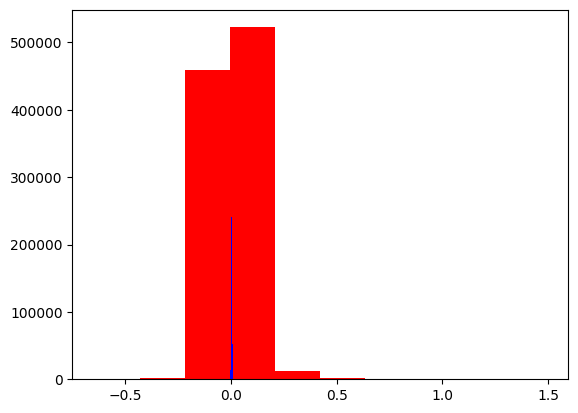

15


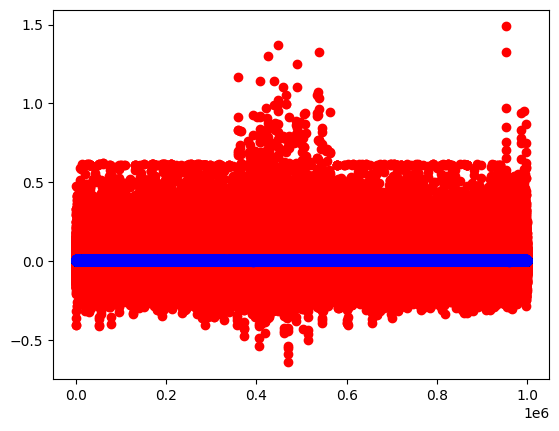

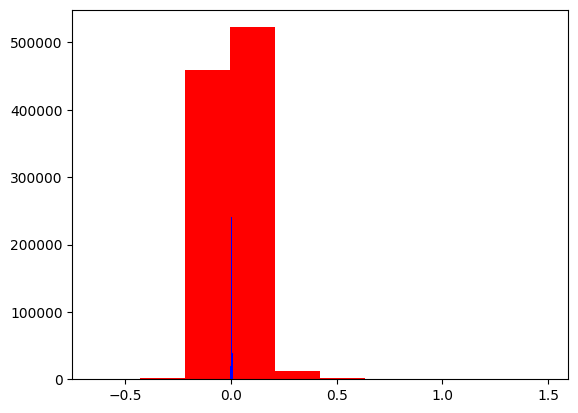

16


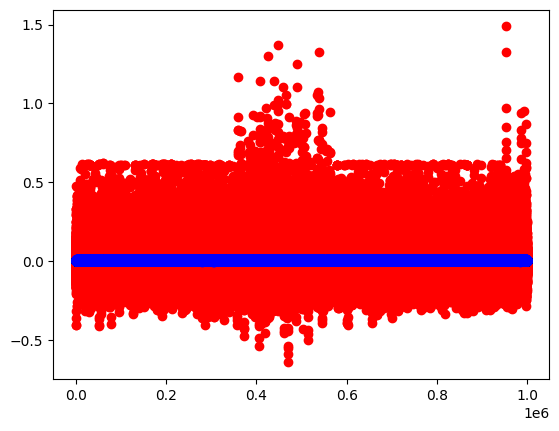

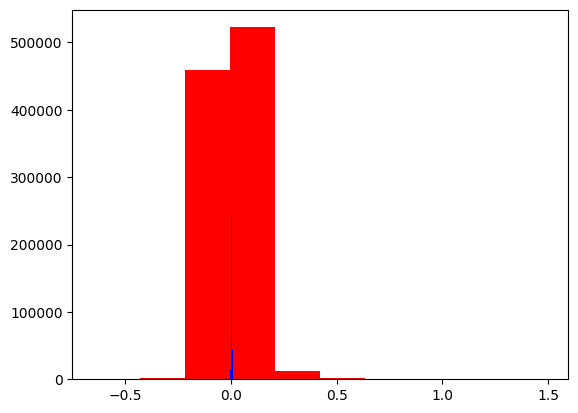

17


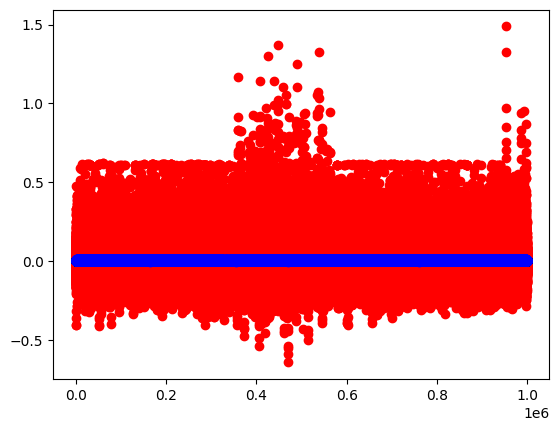

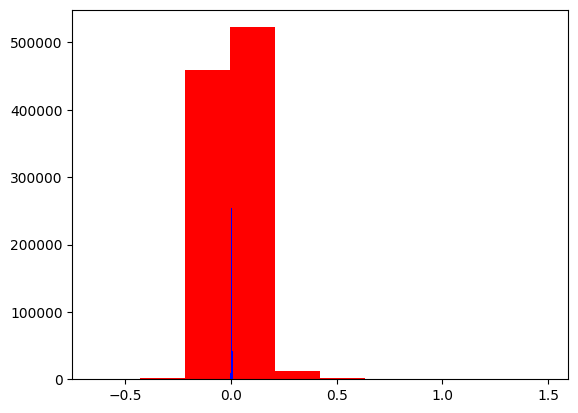

18


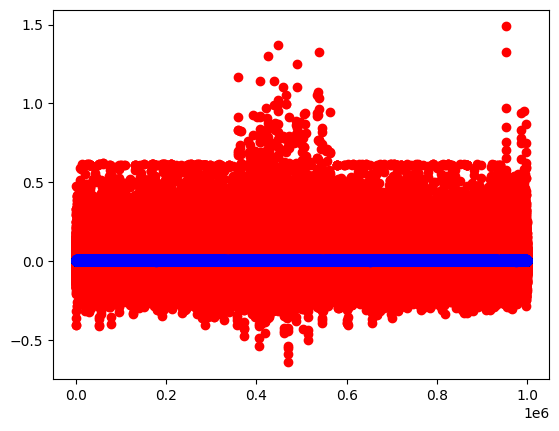

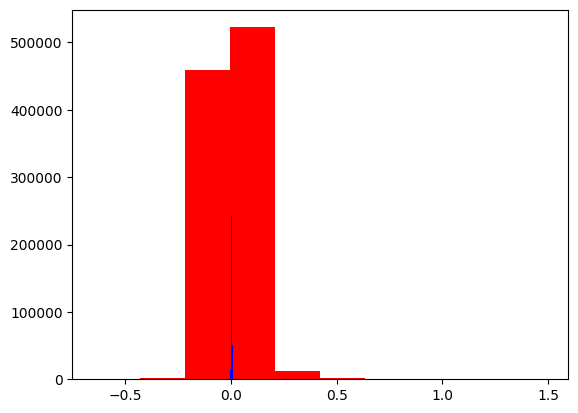

19


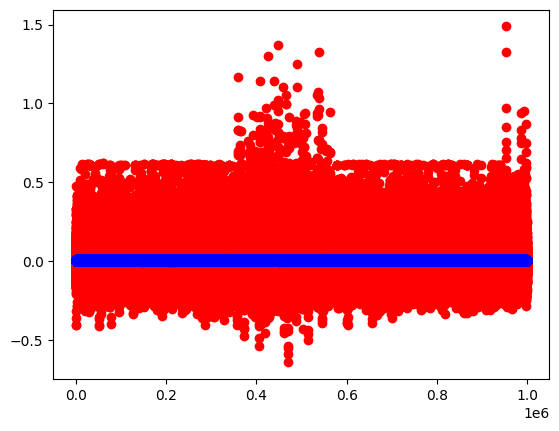

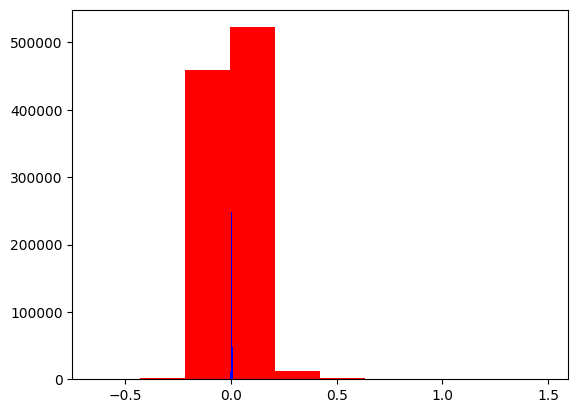

20


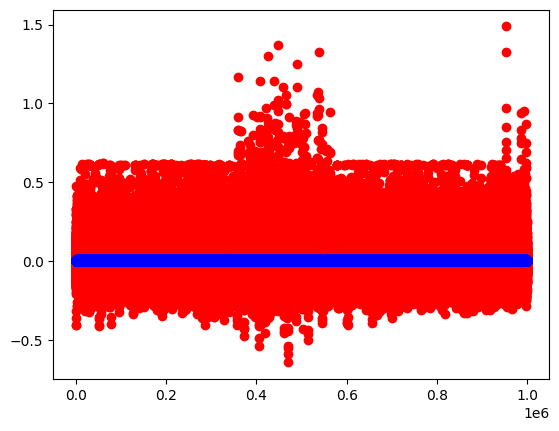

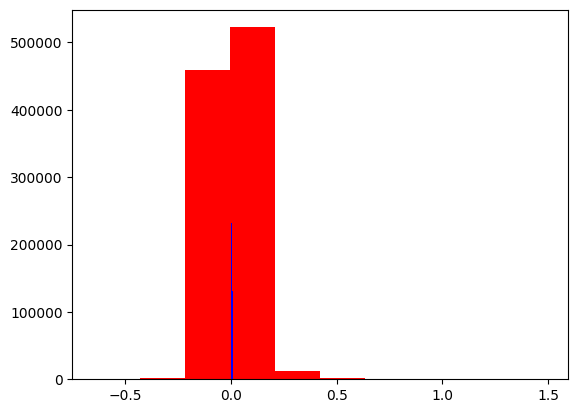

21


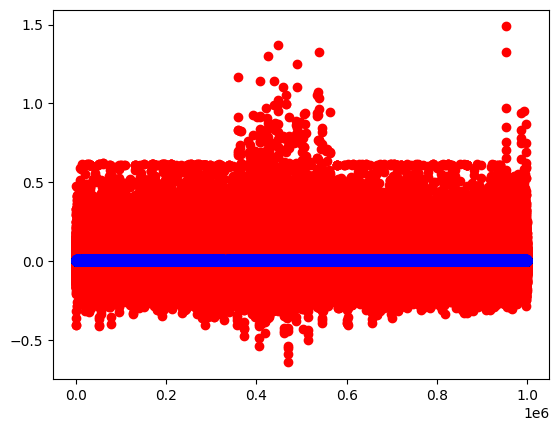

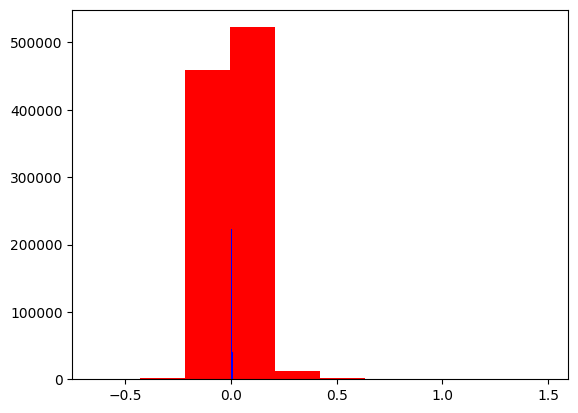

22


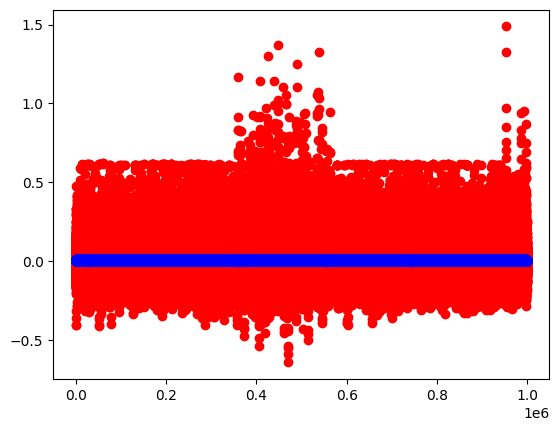

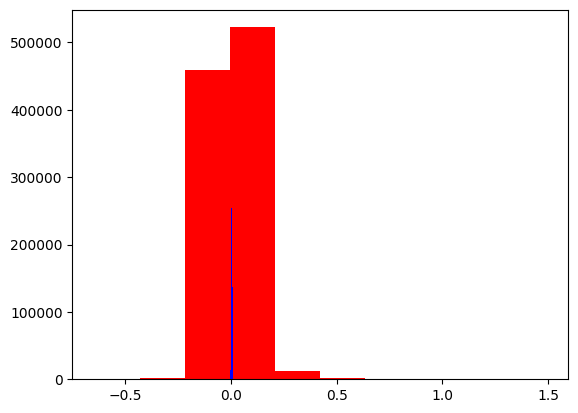

23


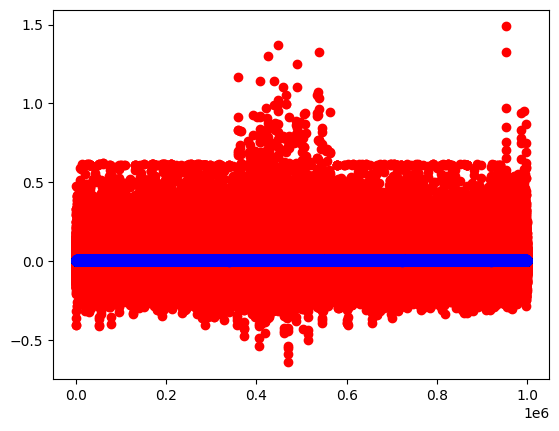

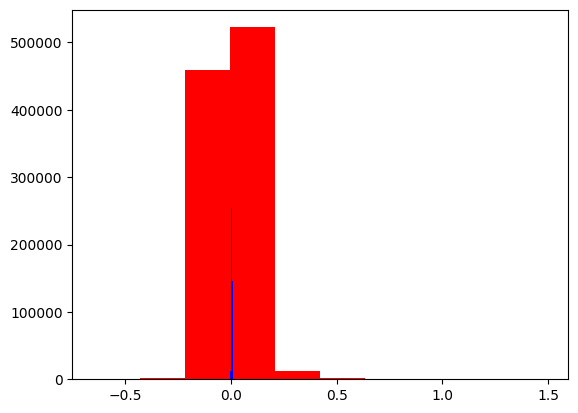

24


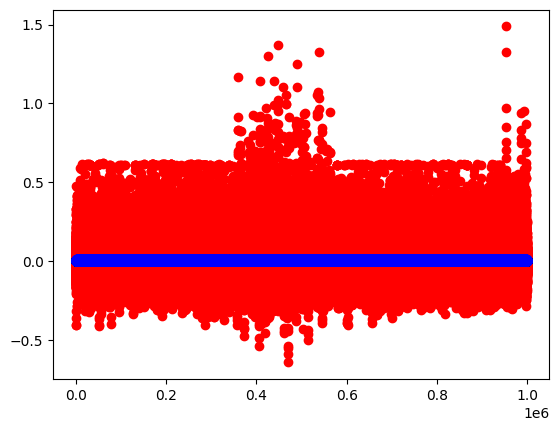

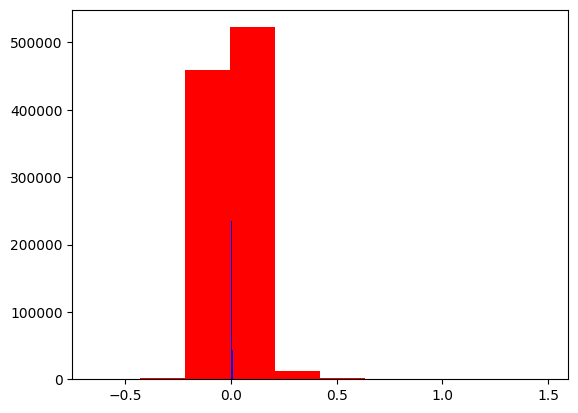

25


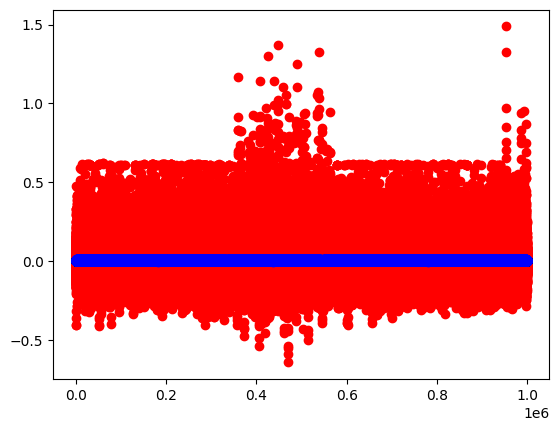

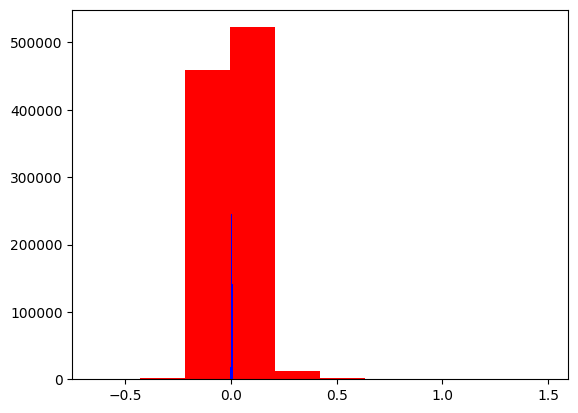

26


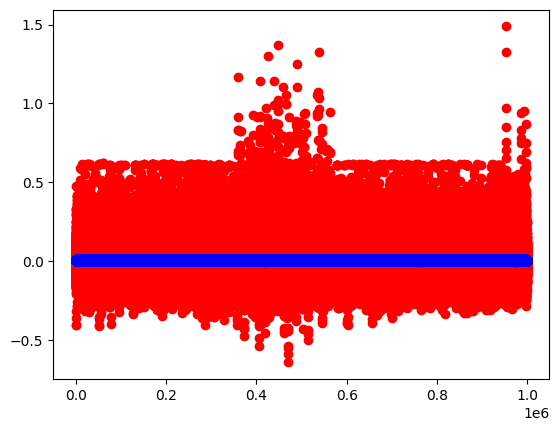

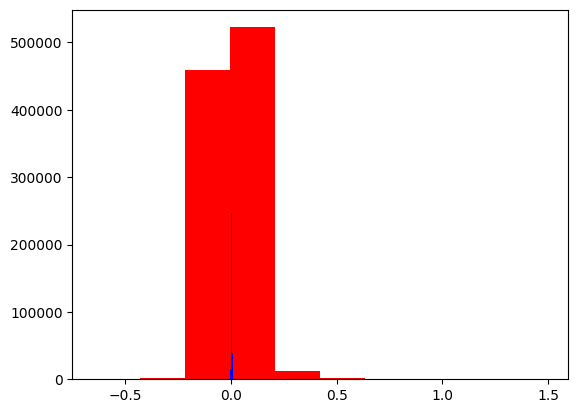

27


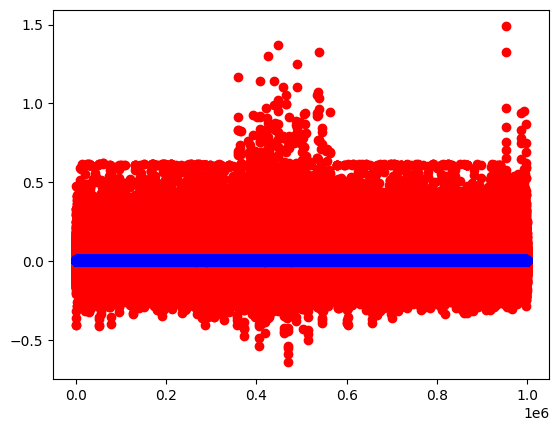

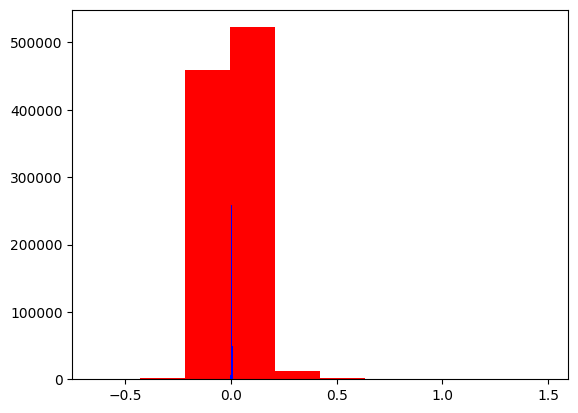

28


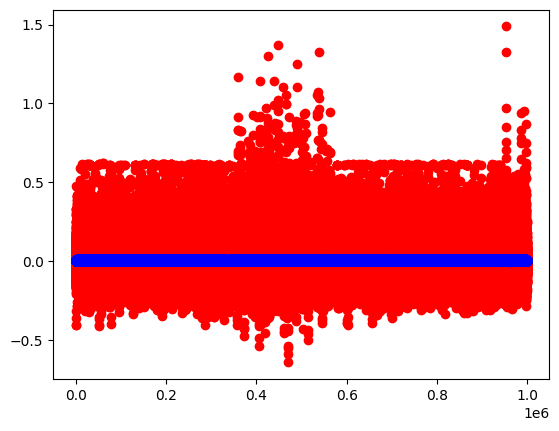

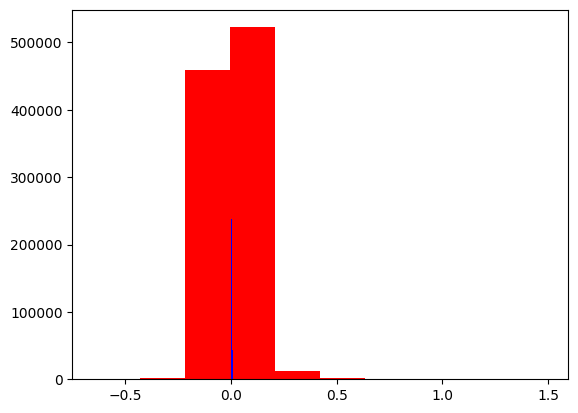

29


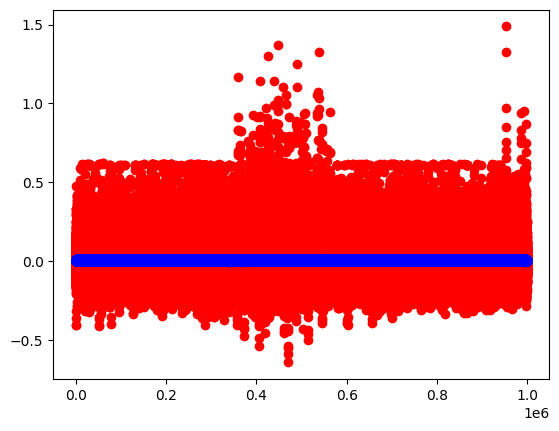

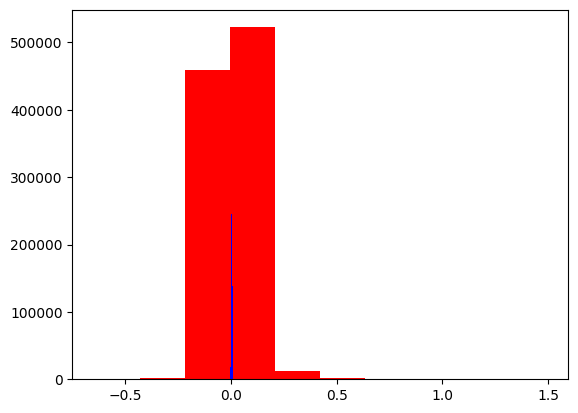

30


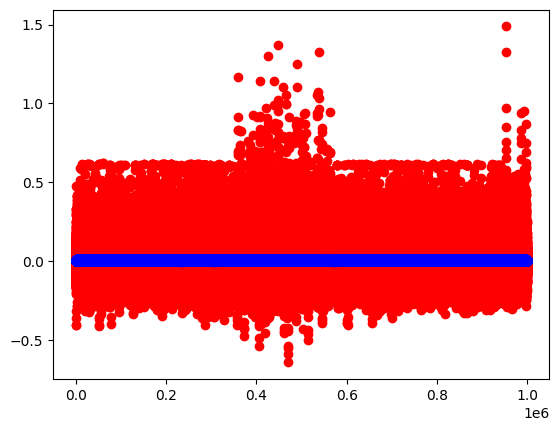

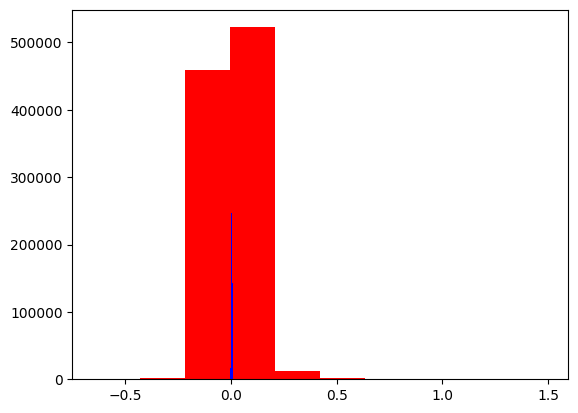

31


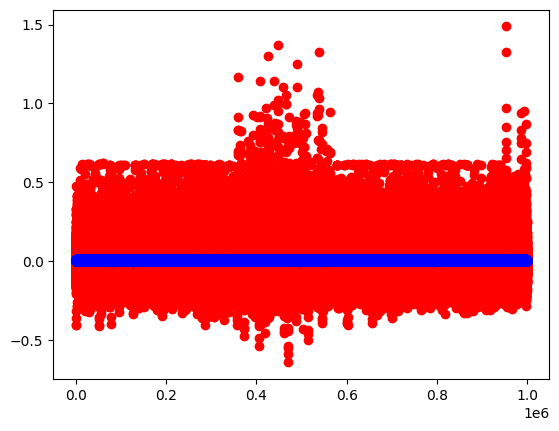

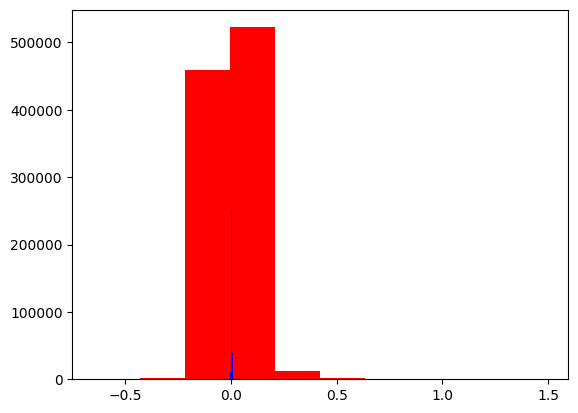

32


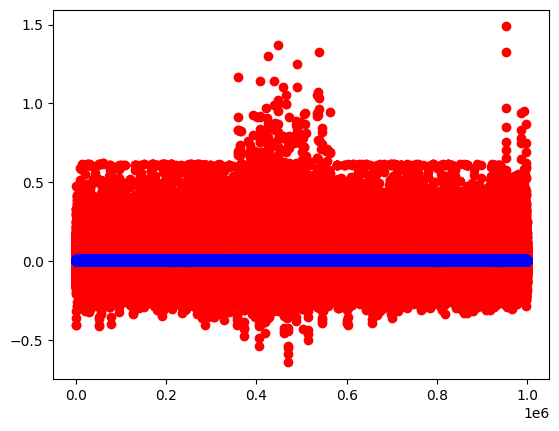

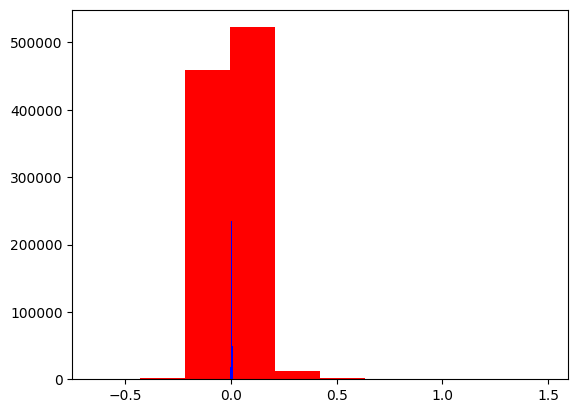

33


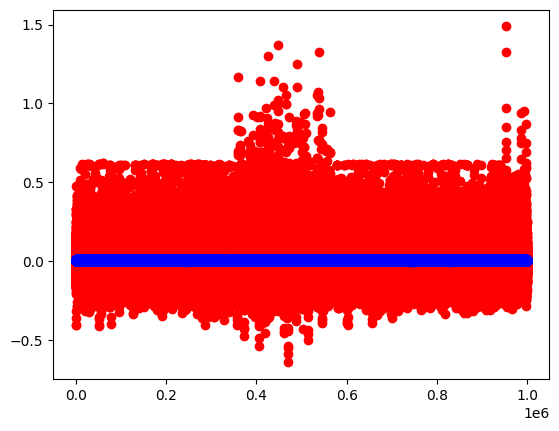

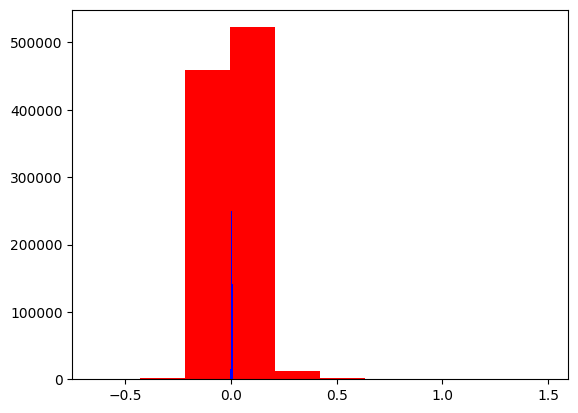

34


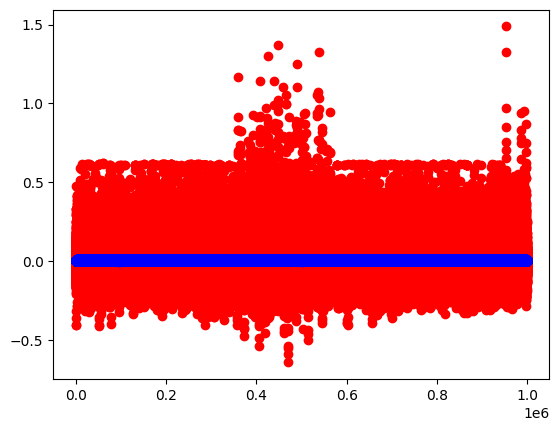

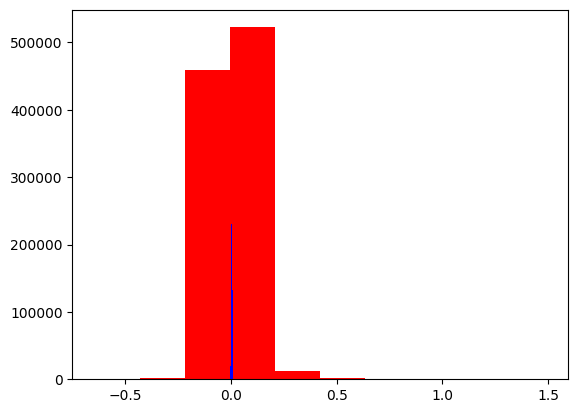

35


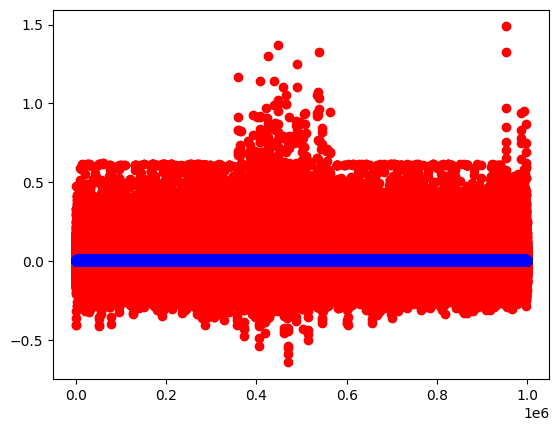

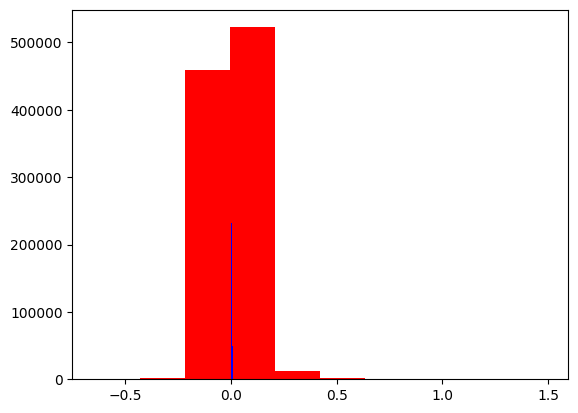

36


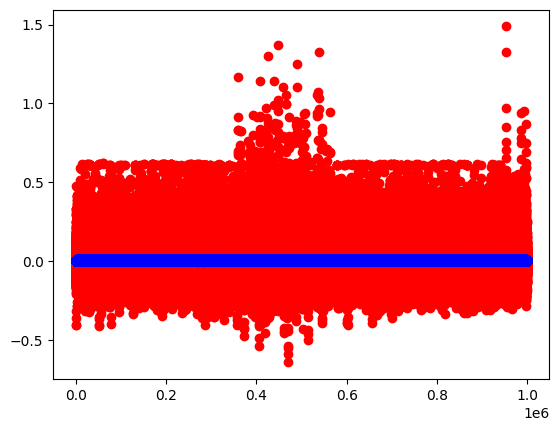

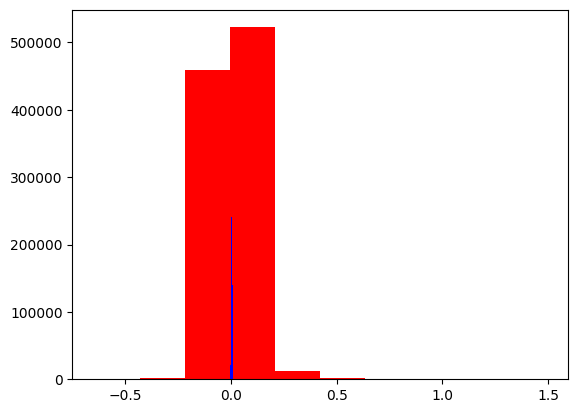

37


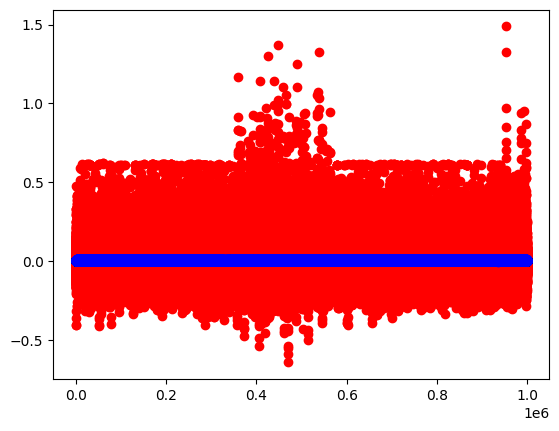

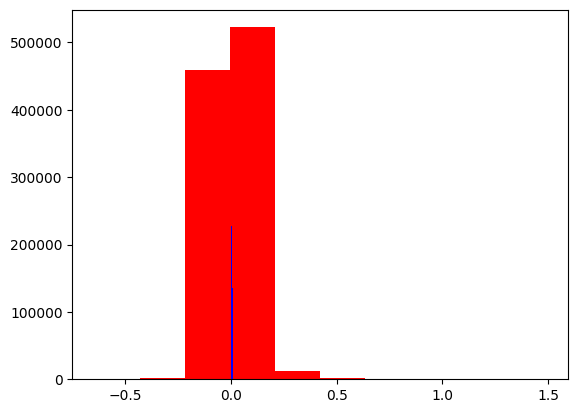

38


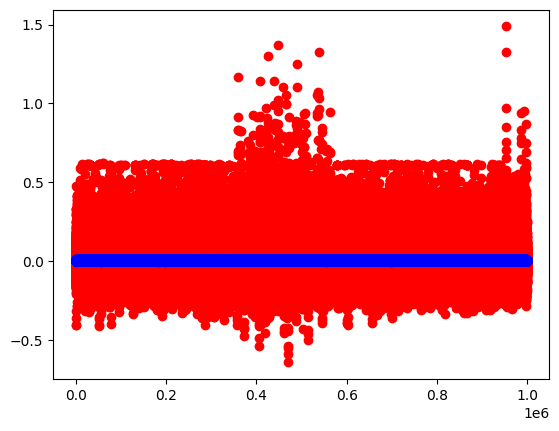

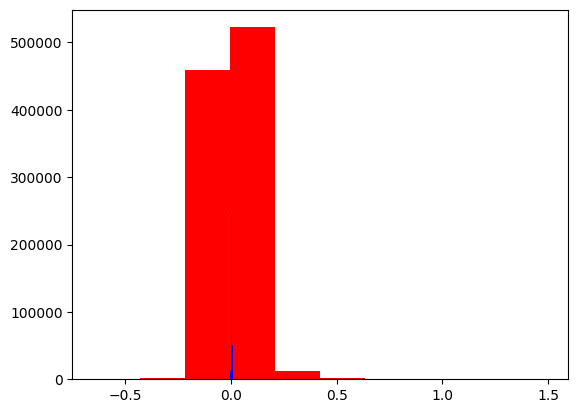

39


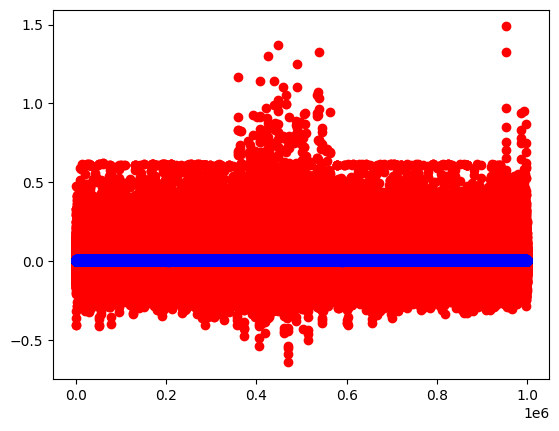

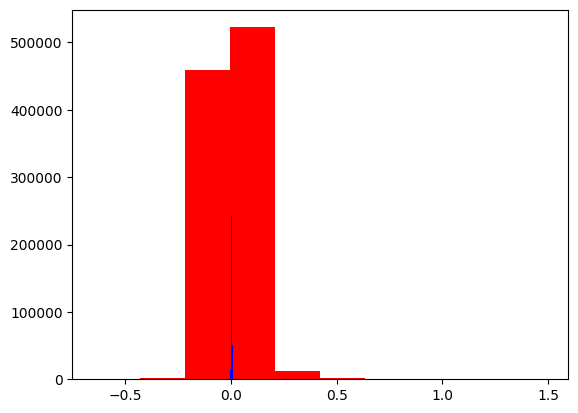

40


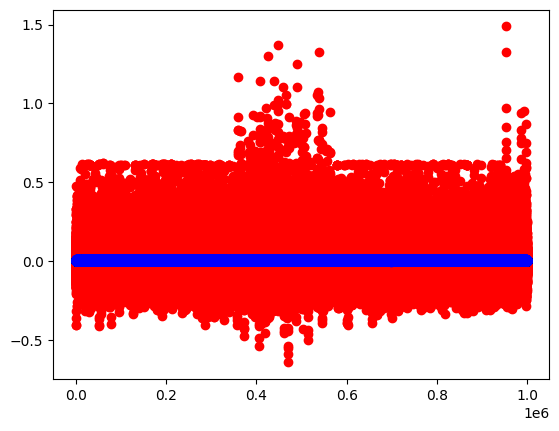

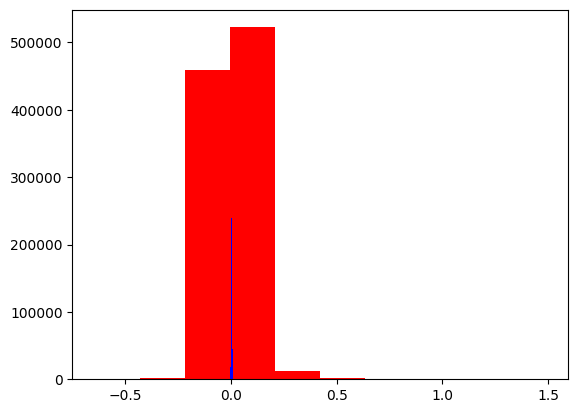

41


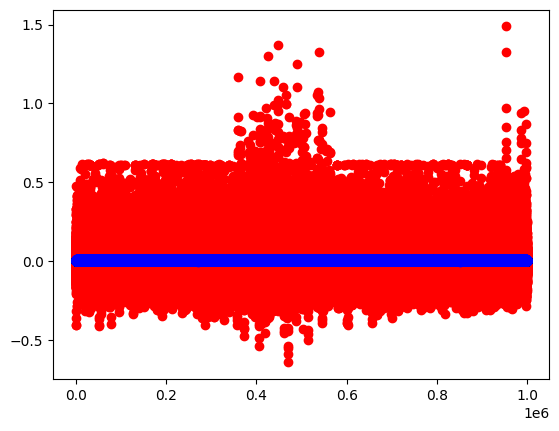

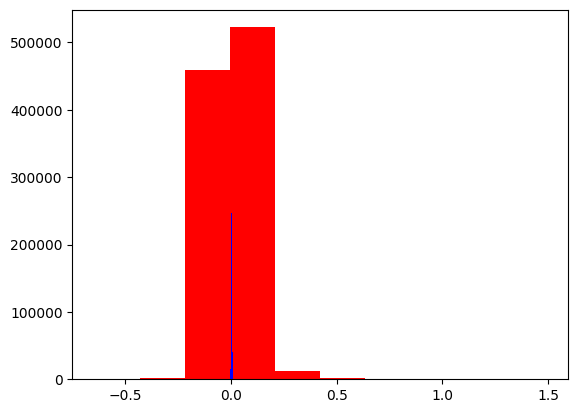

42


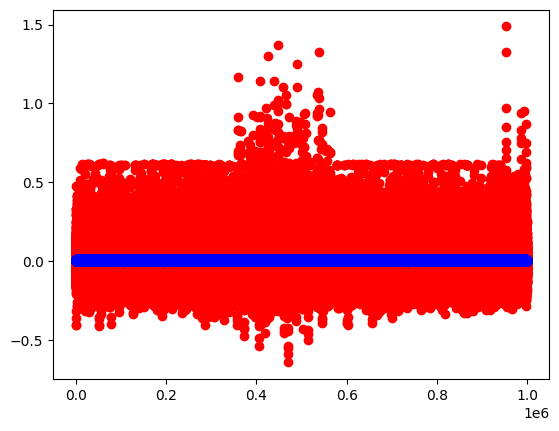

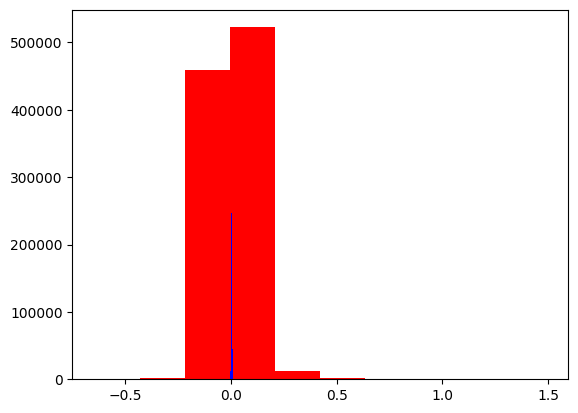

43


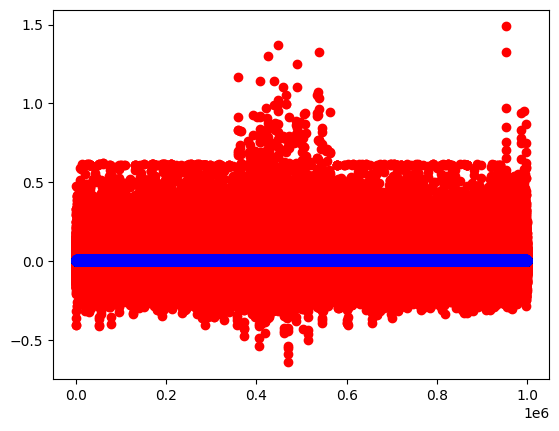

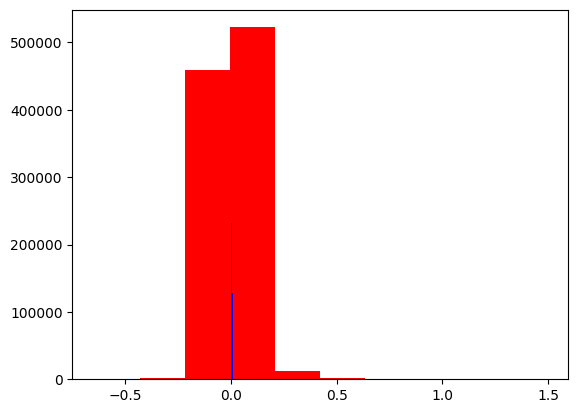

44


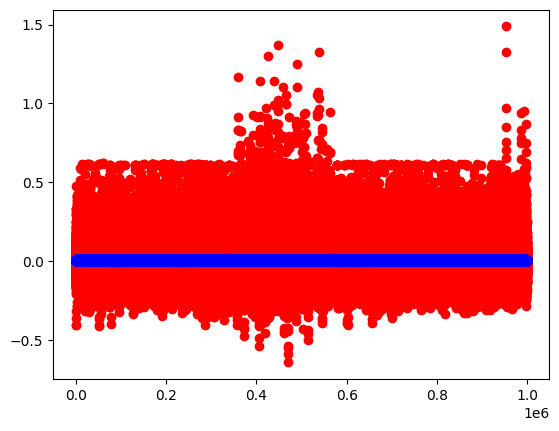

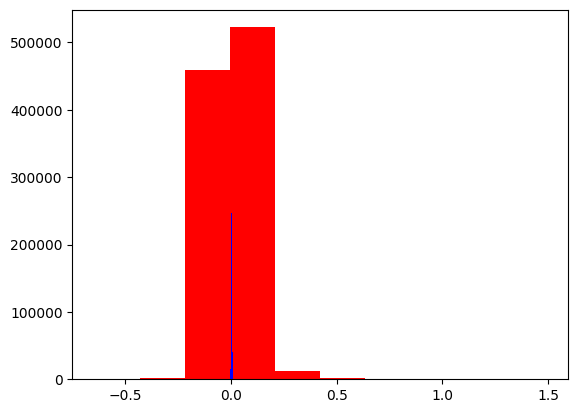

45


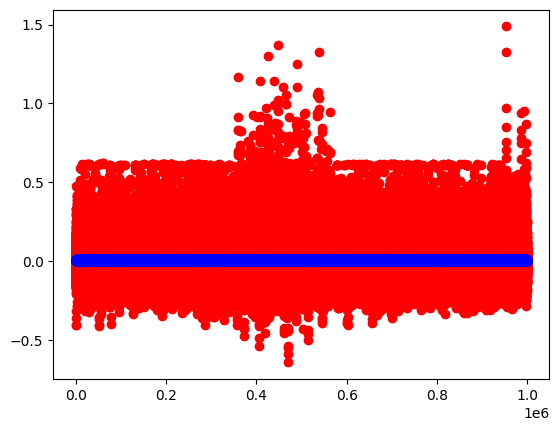

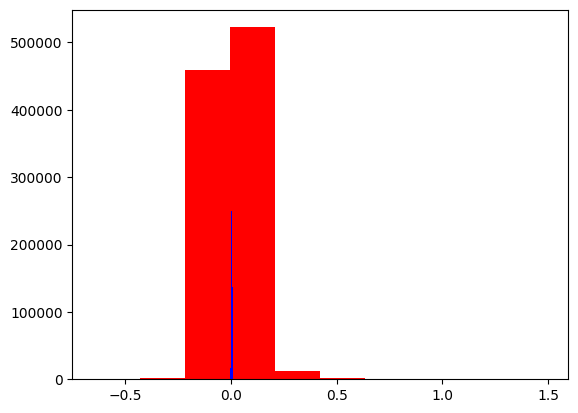

46


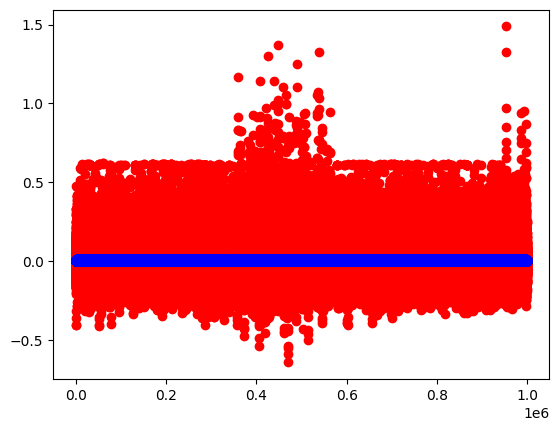

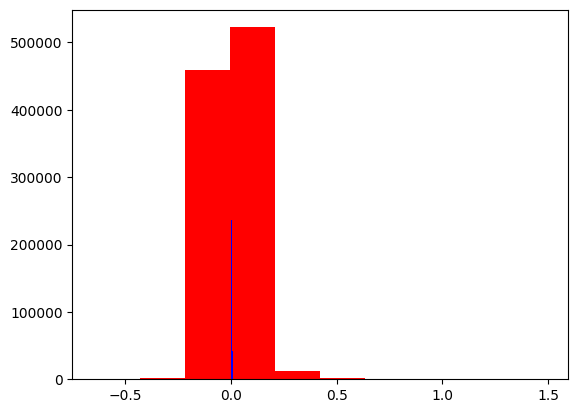

47


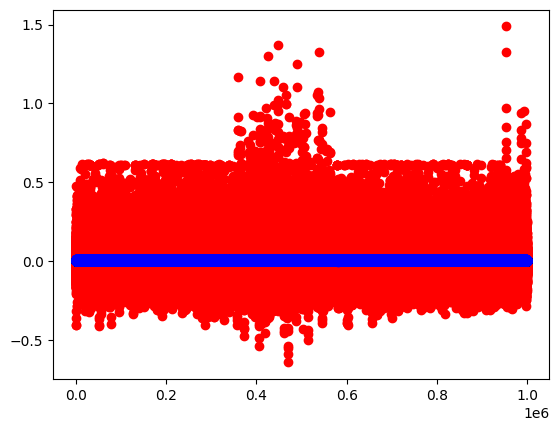

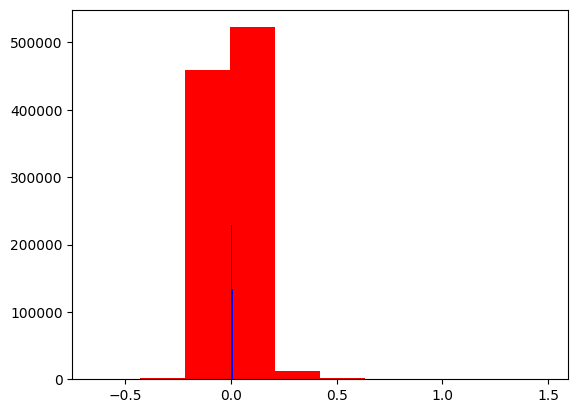

48


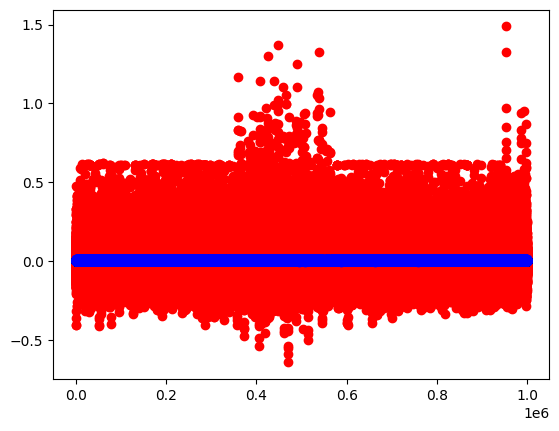

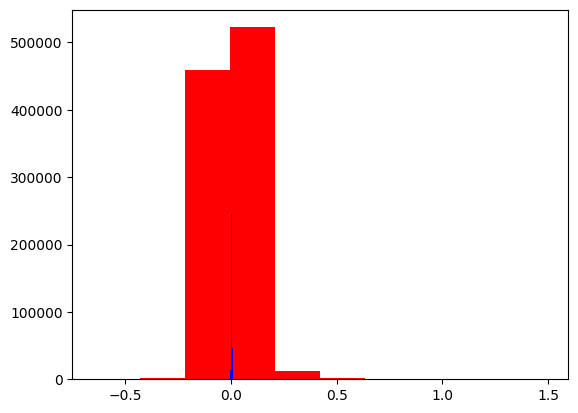

49


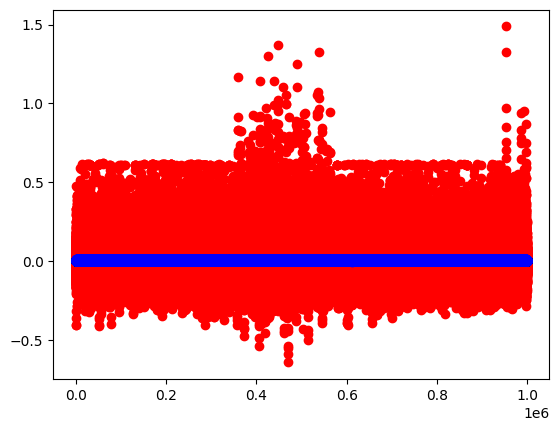

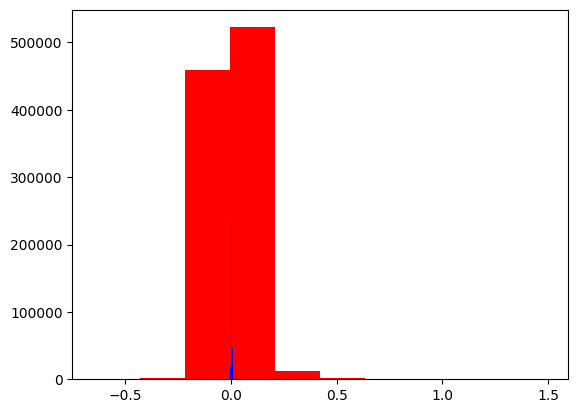

50


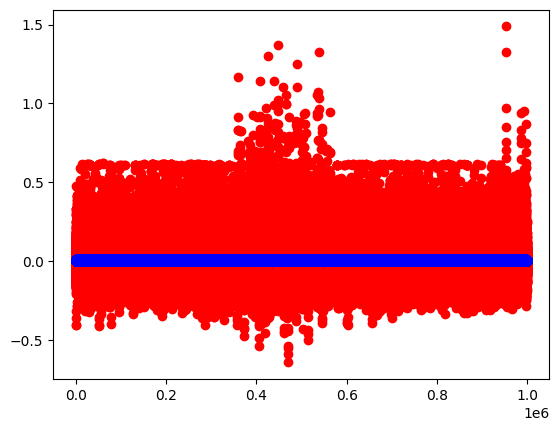

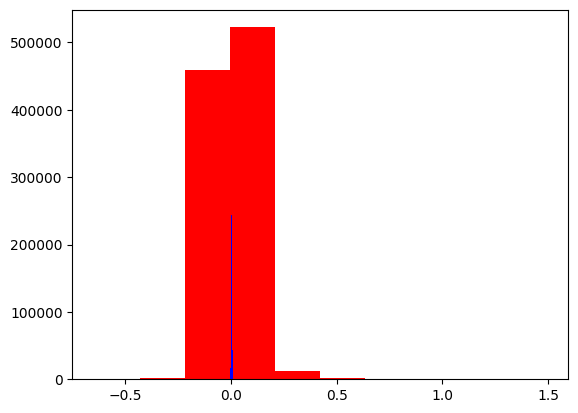

51


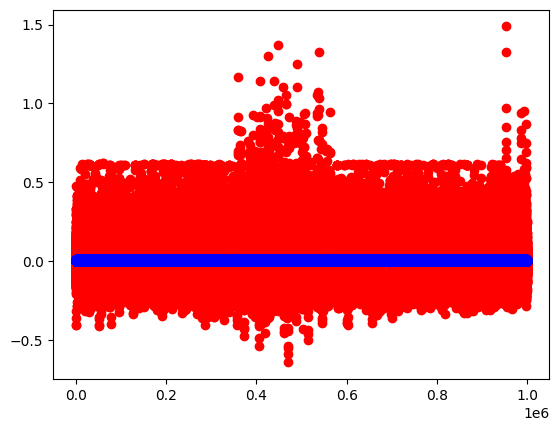

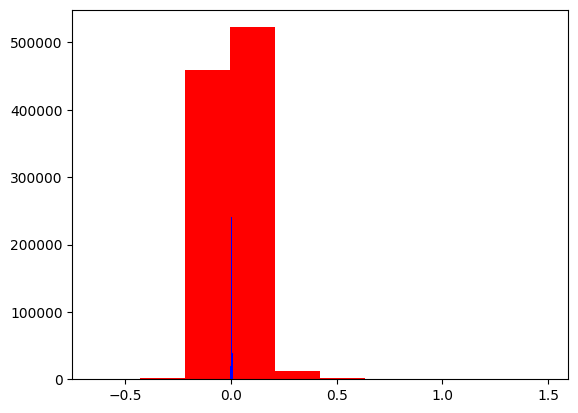

52


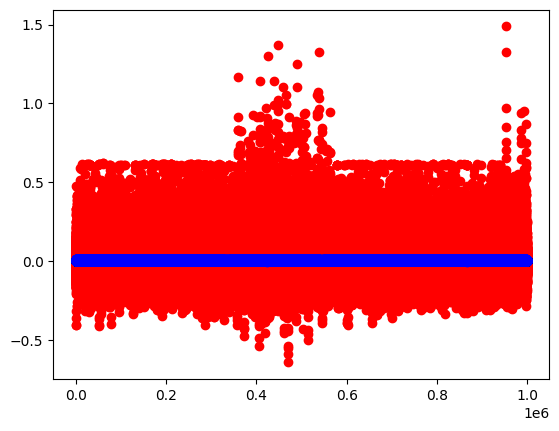

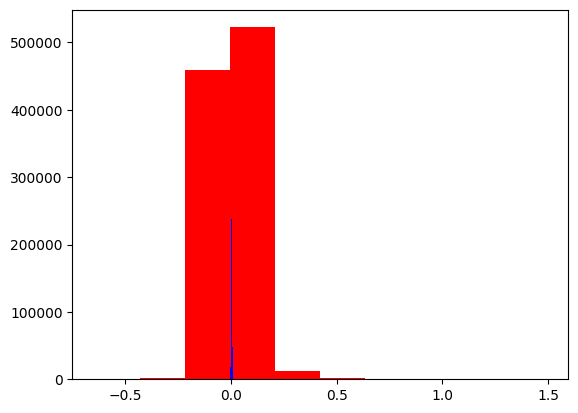

53


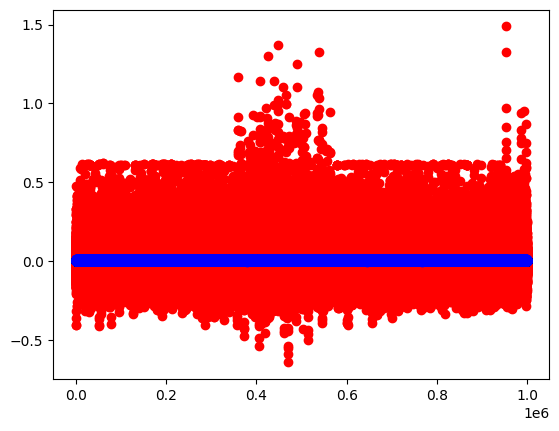

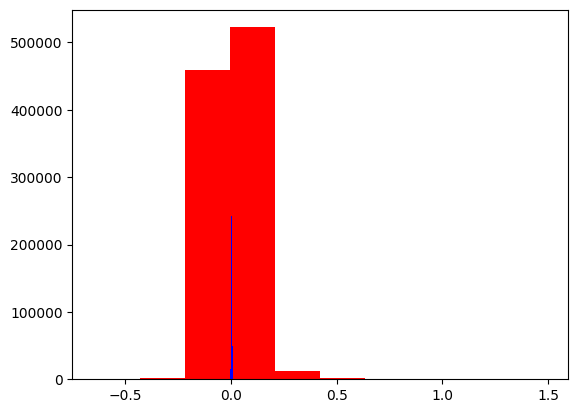

54


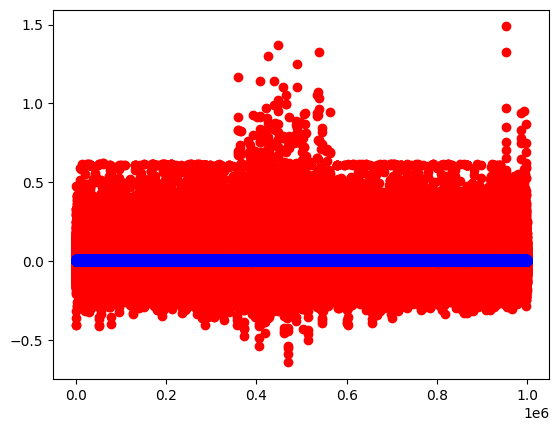

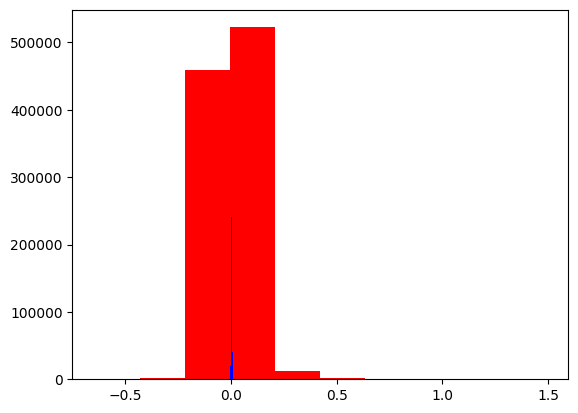

55


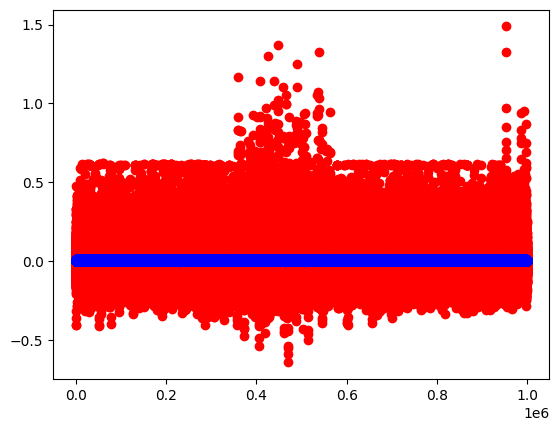

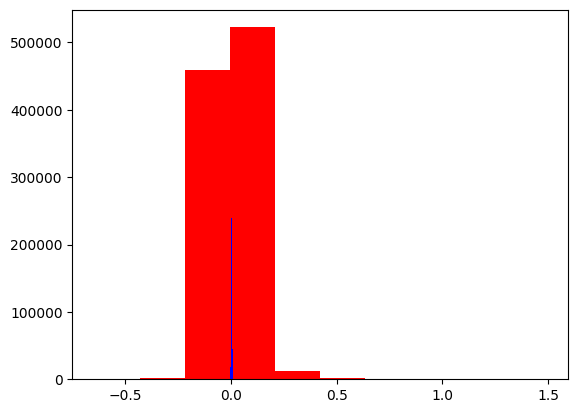

56


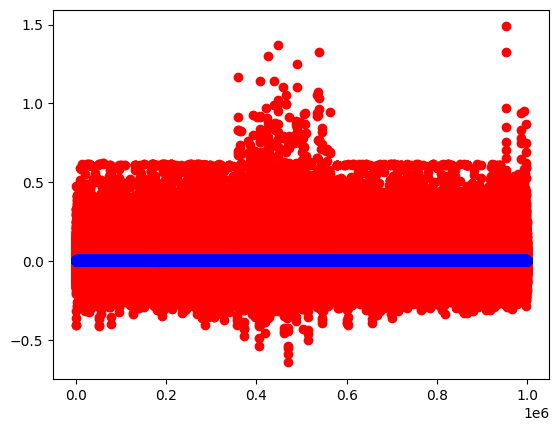

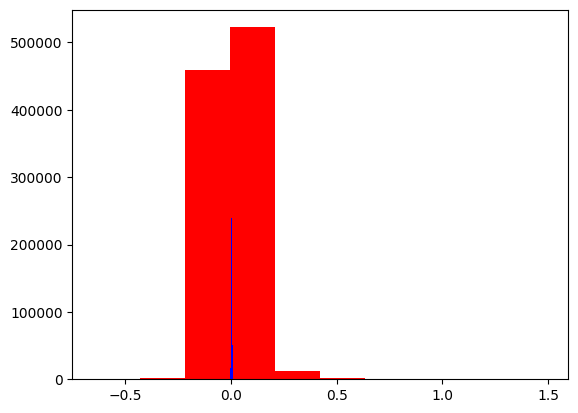

57


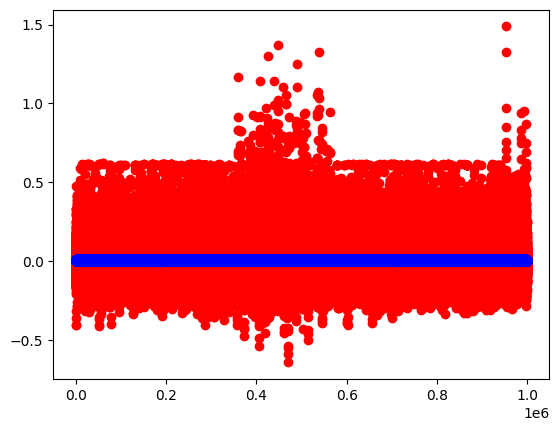

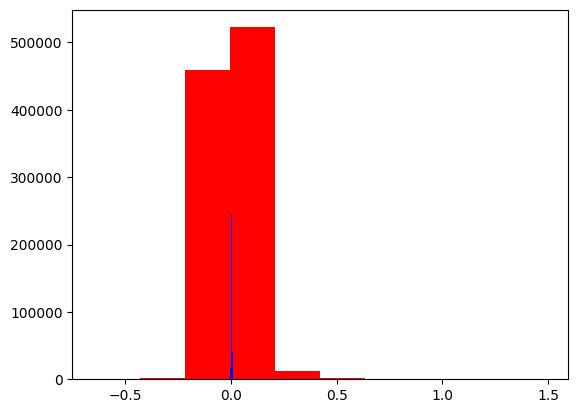

58


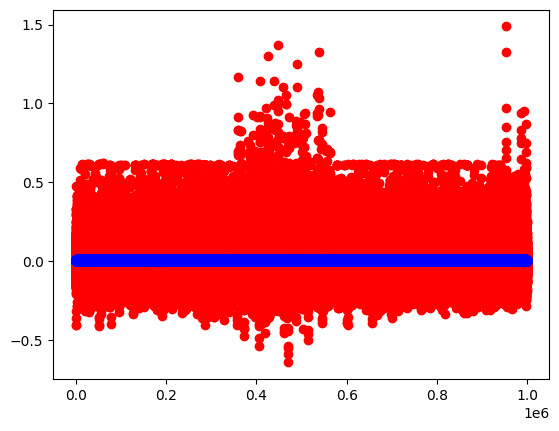

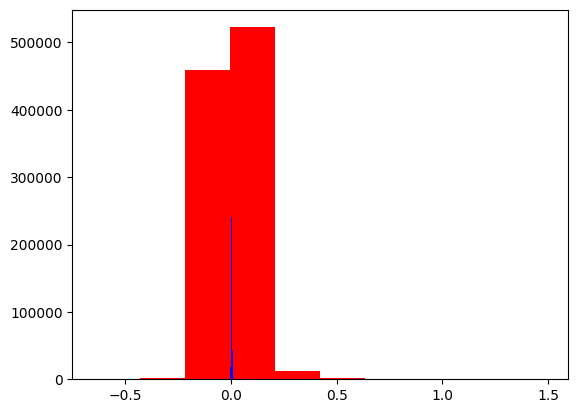

59


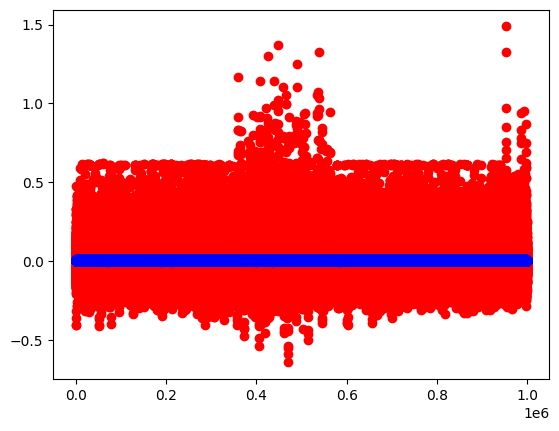

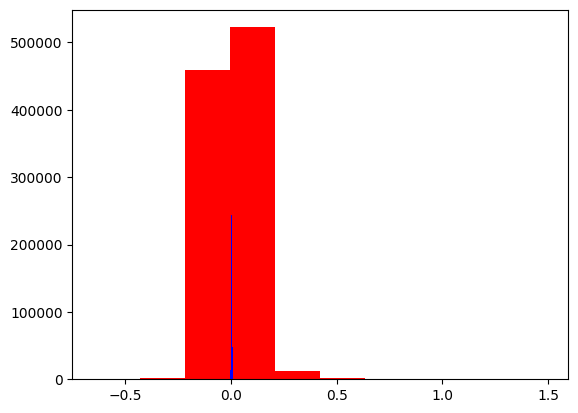

60


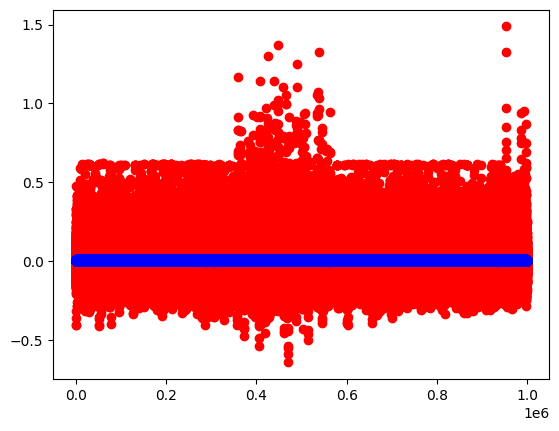

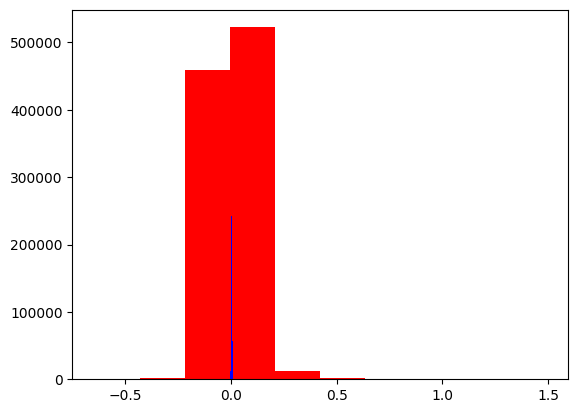

61


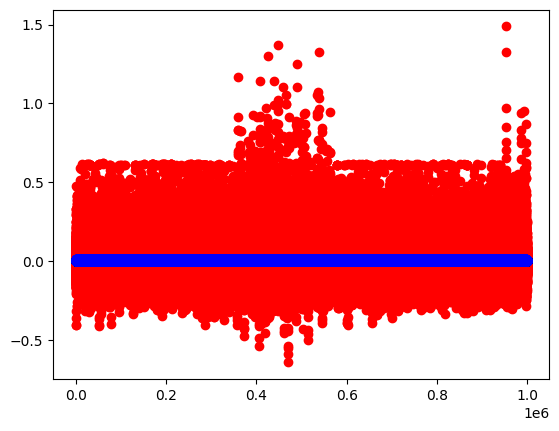

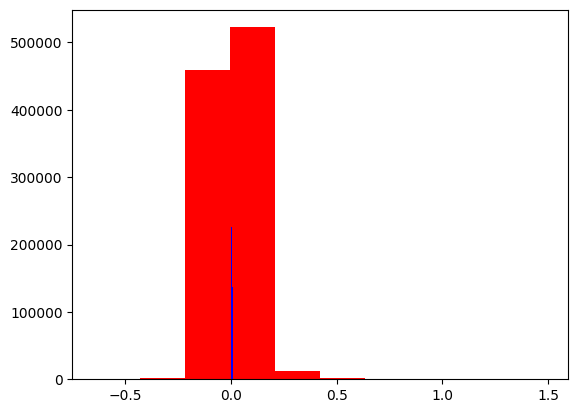

62


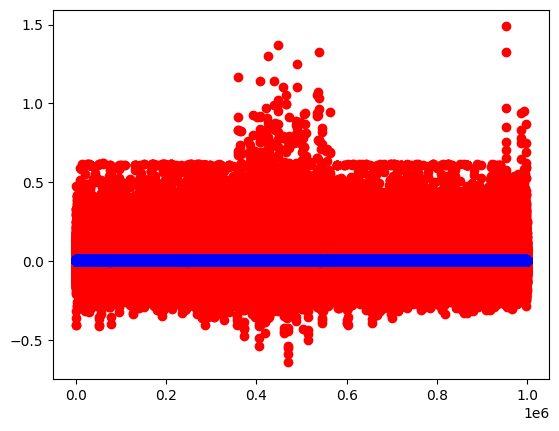

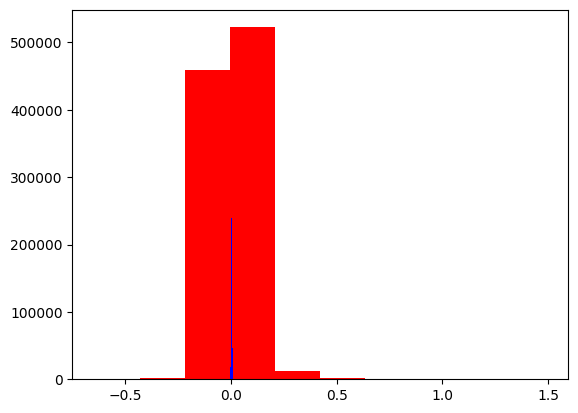

63


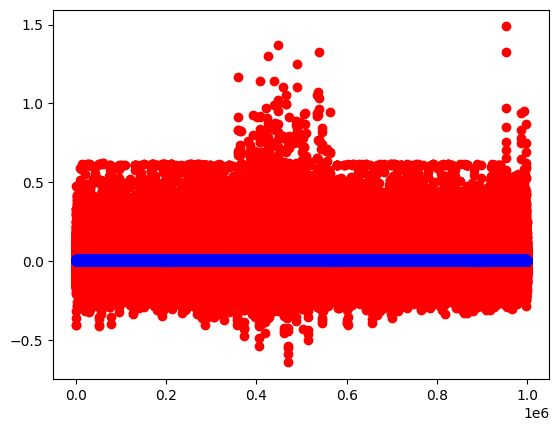

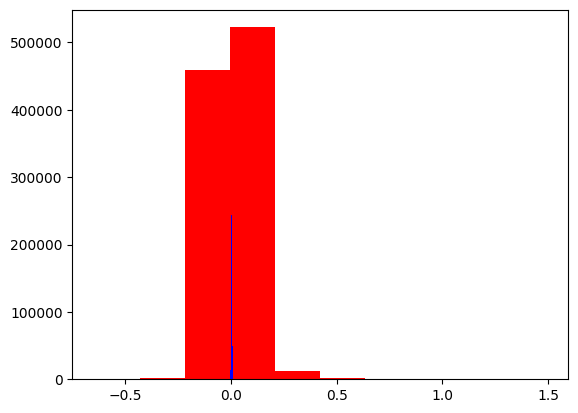

64


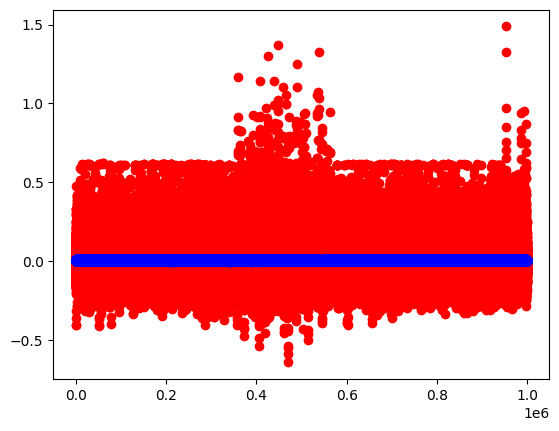

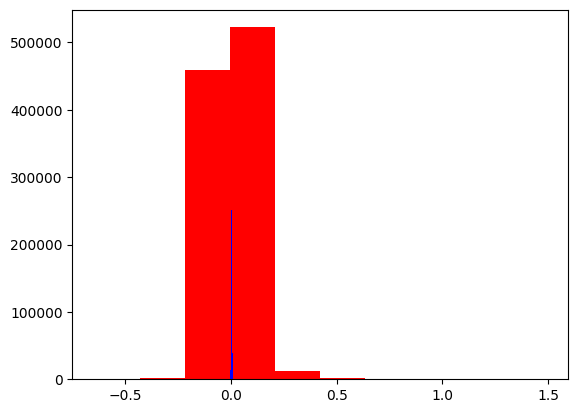

65


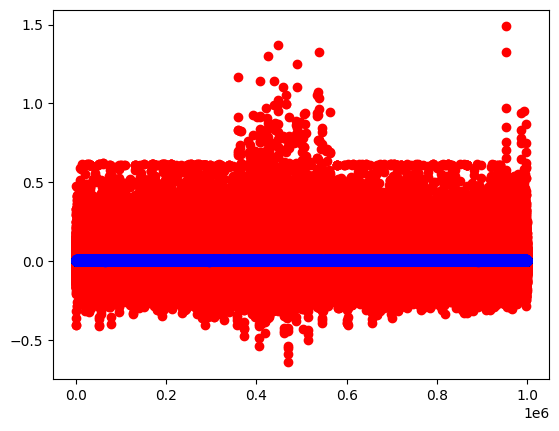

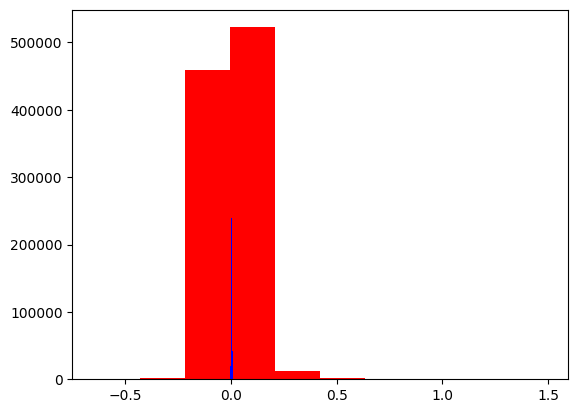

66


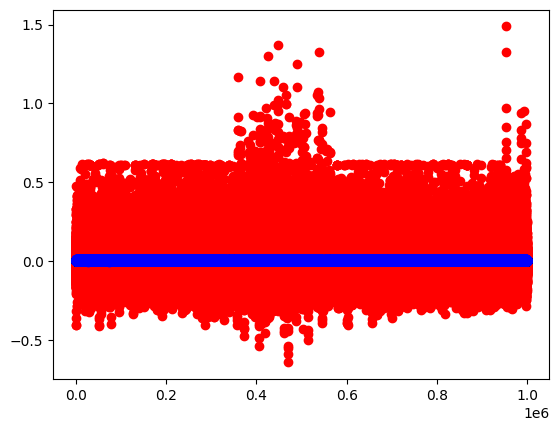

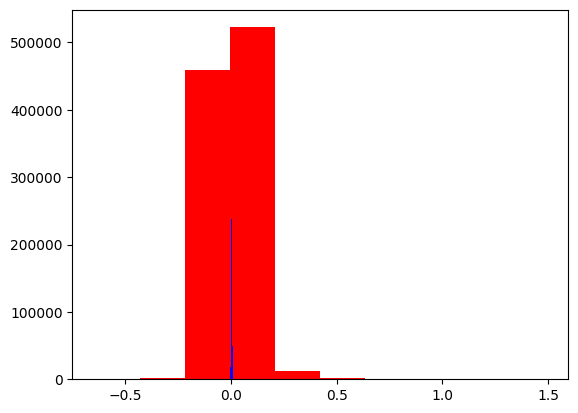

67


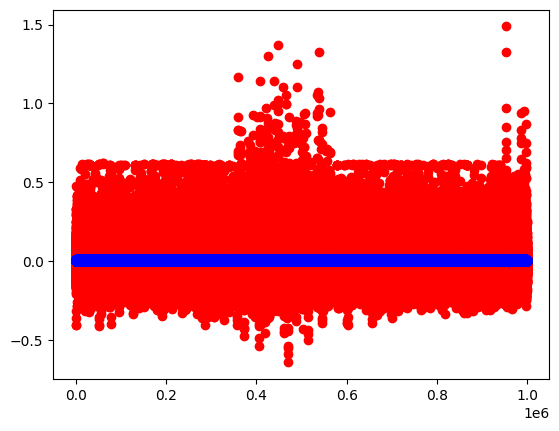

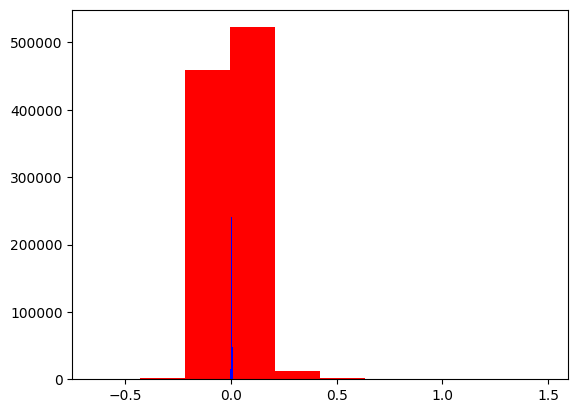

68


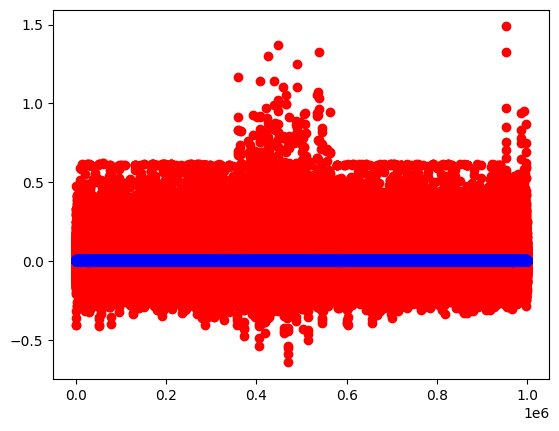

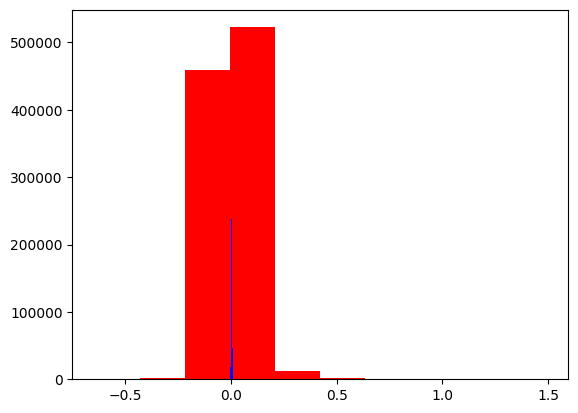

69


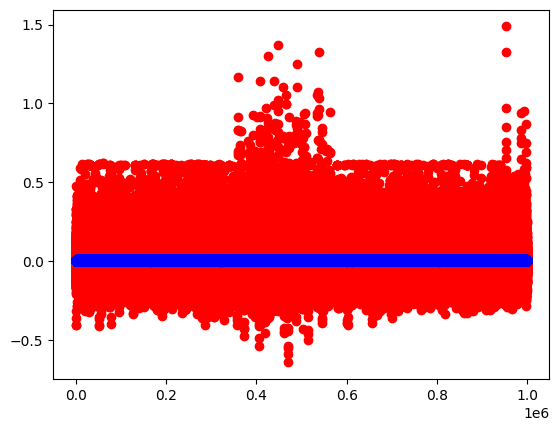

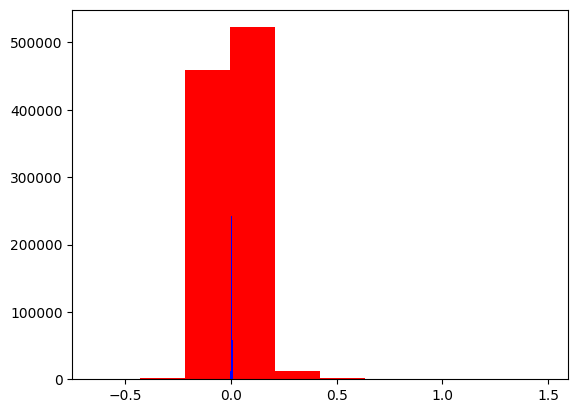

70


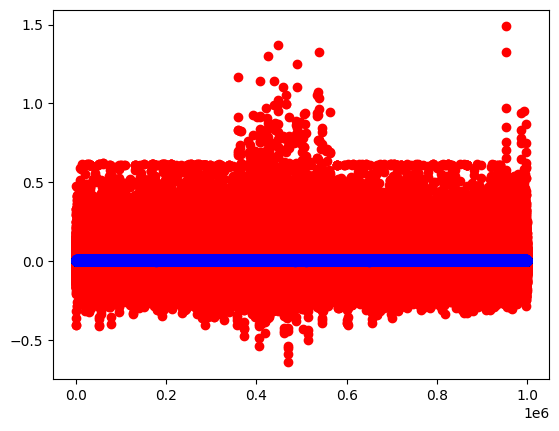

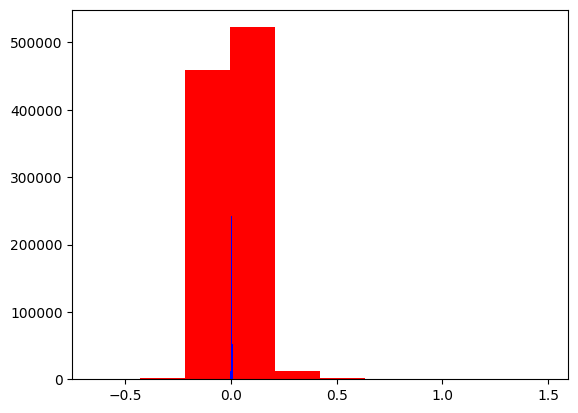

71


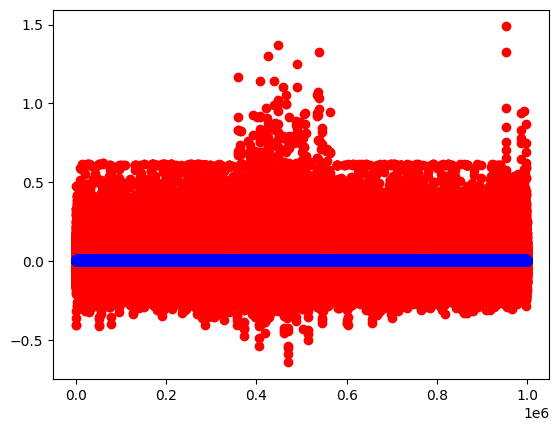

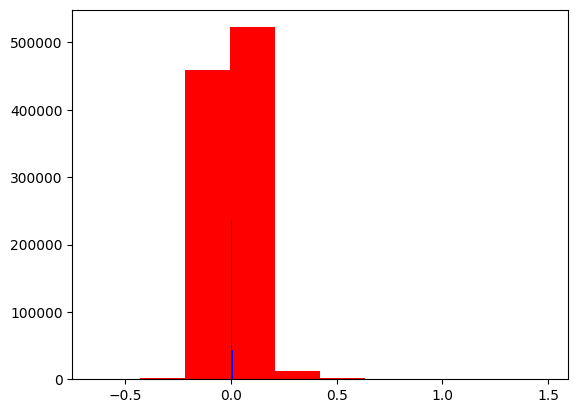

72


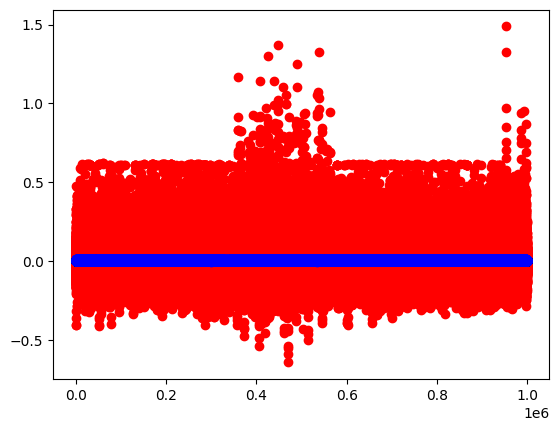

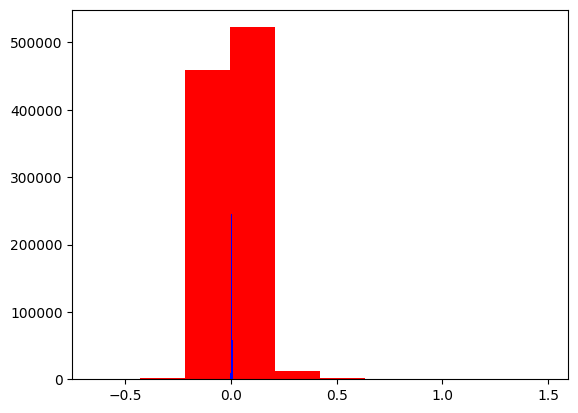

73


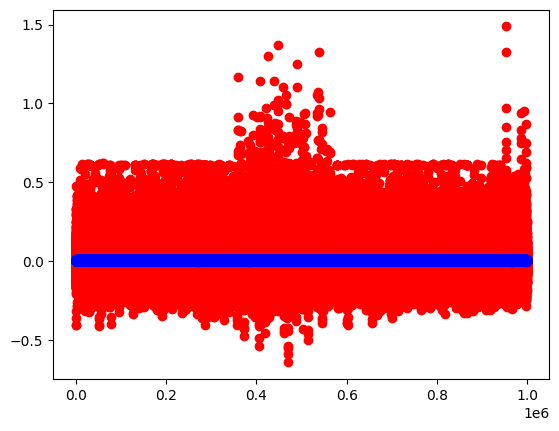

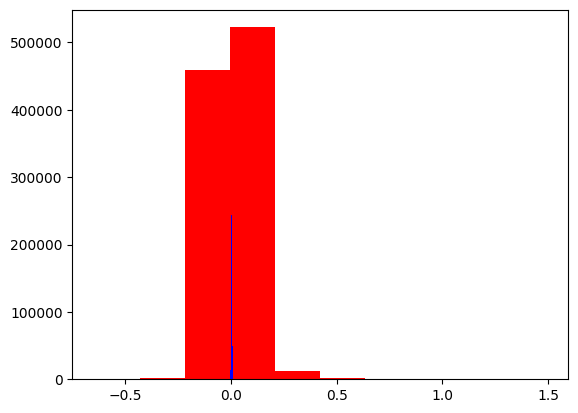

74


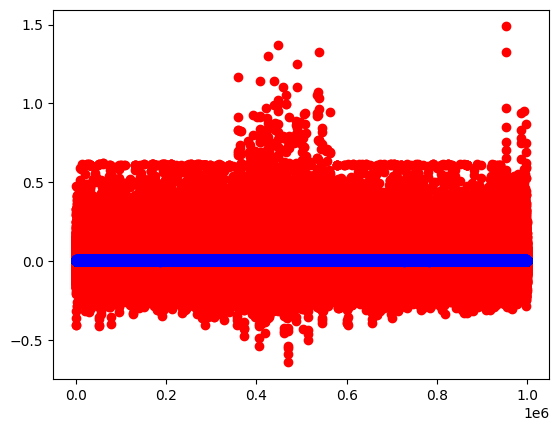

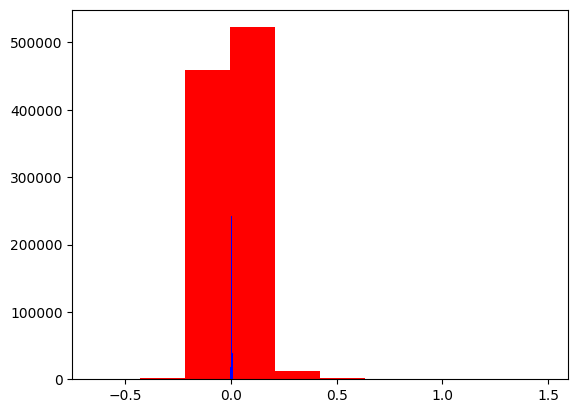

75


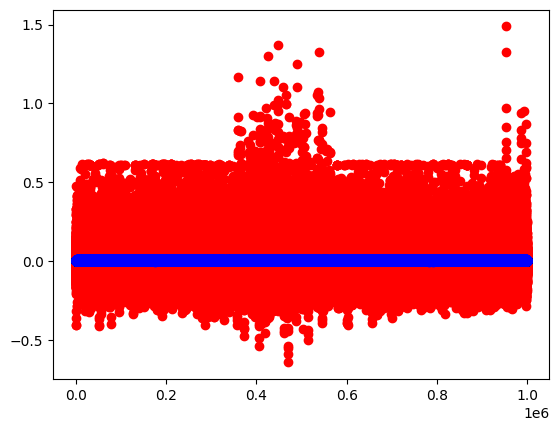

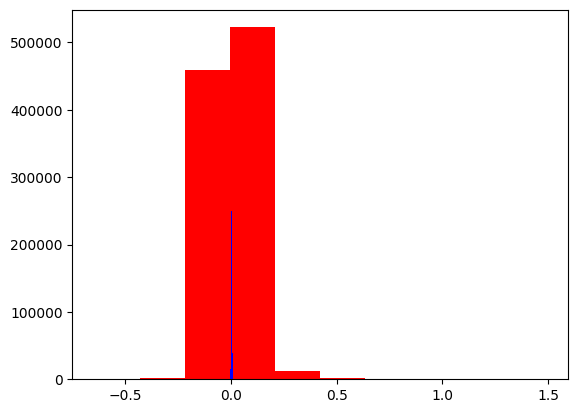

76


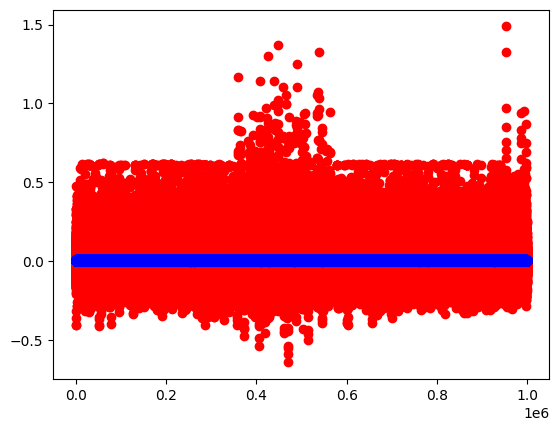

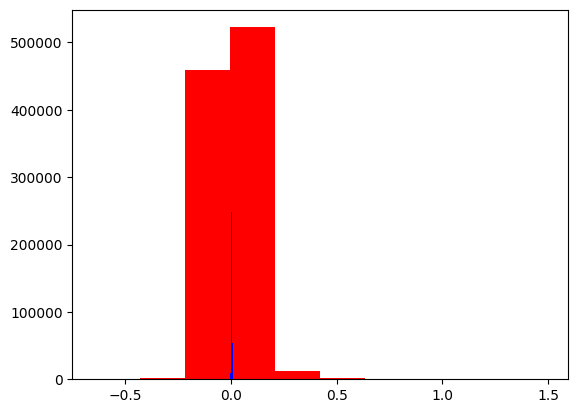

77


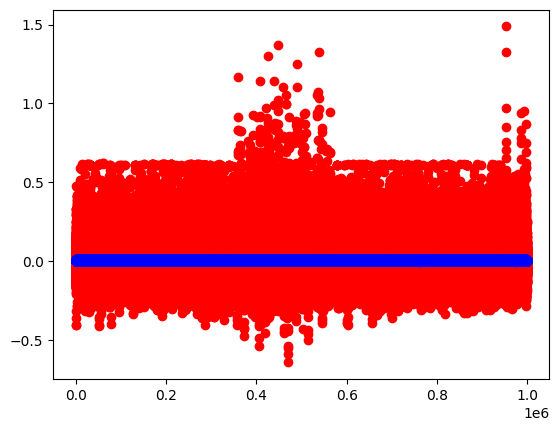

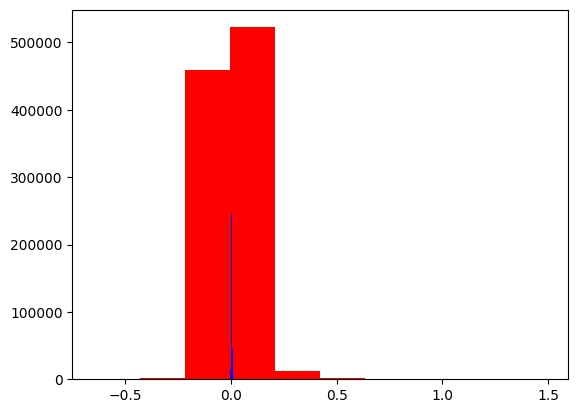

78


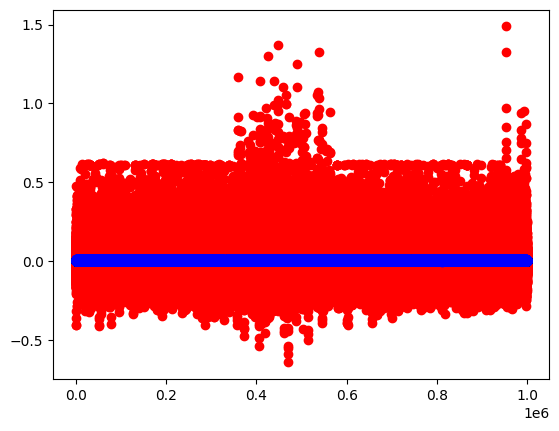

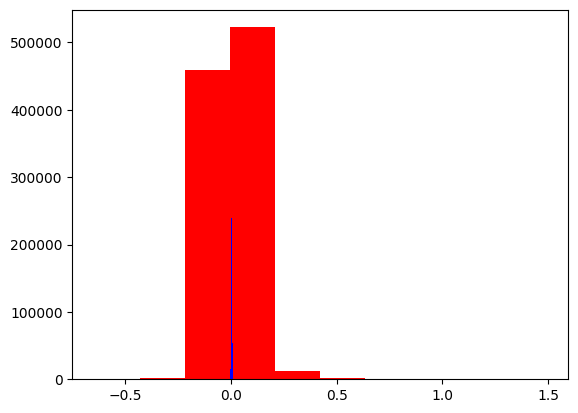

79


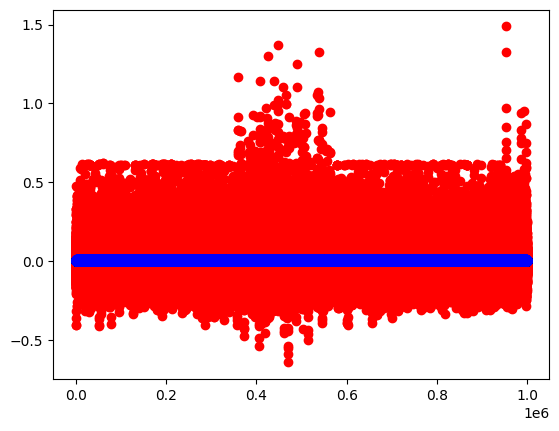

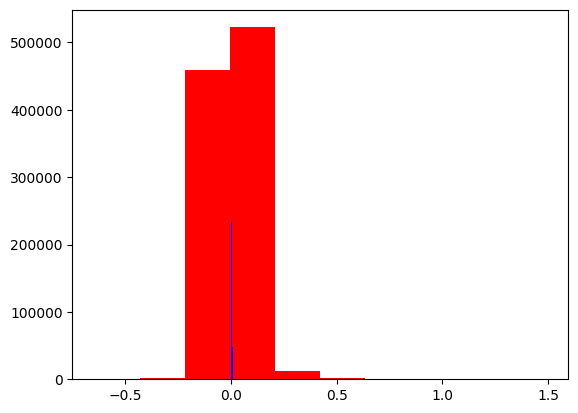

80


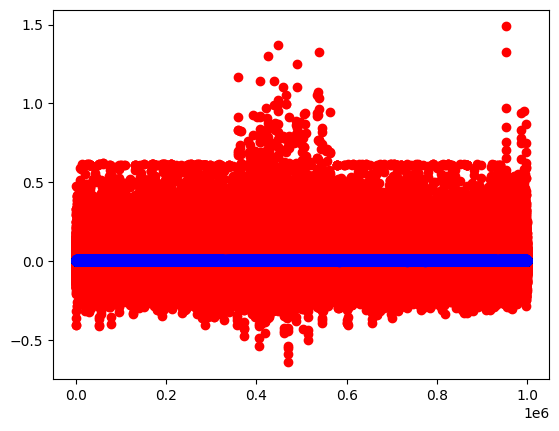

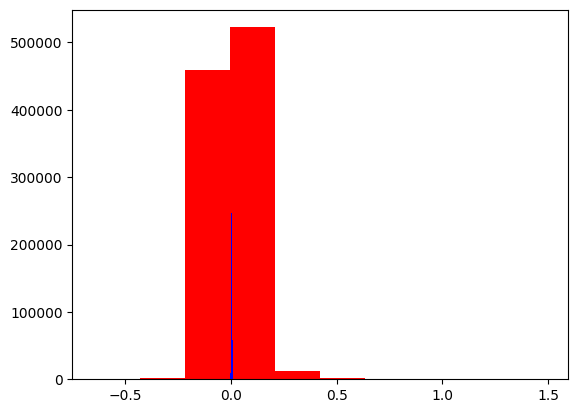

81


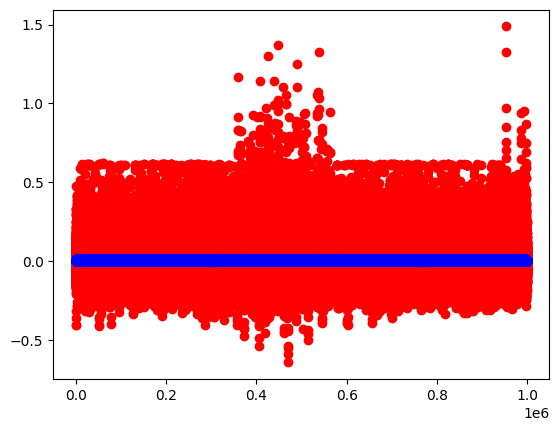

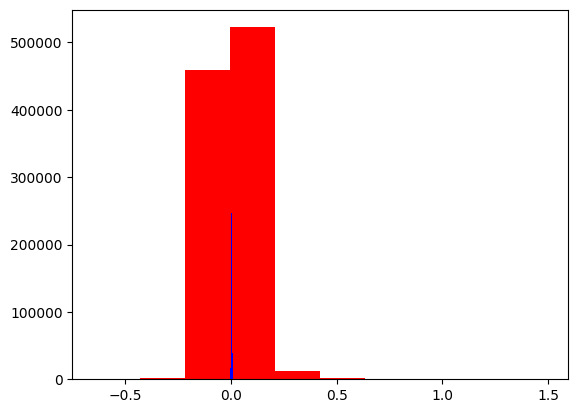

82


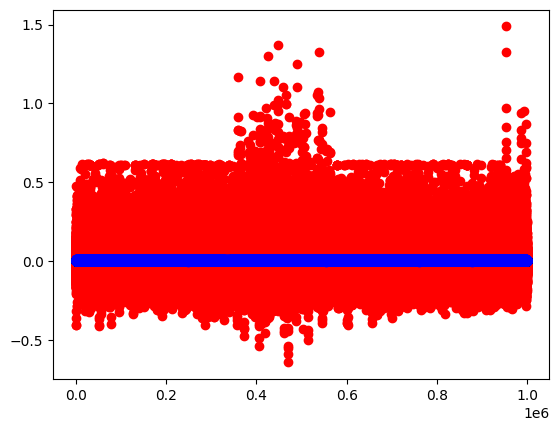

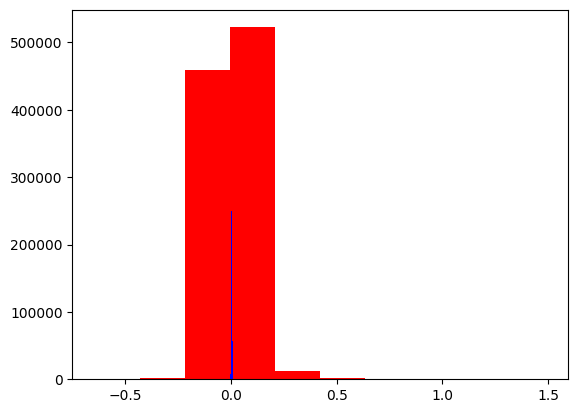

83


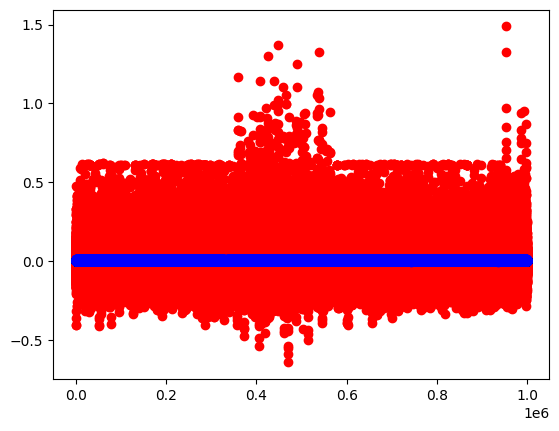

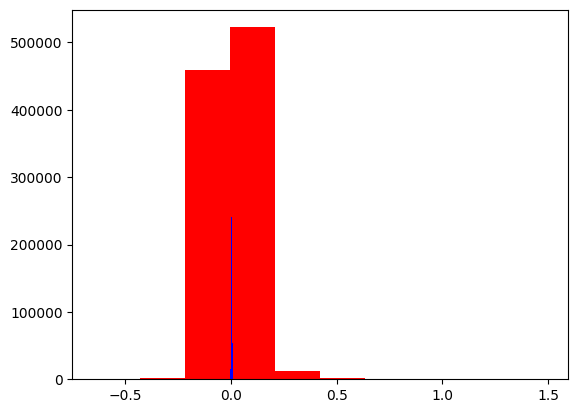

84


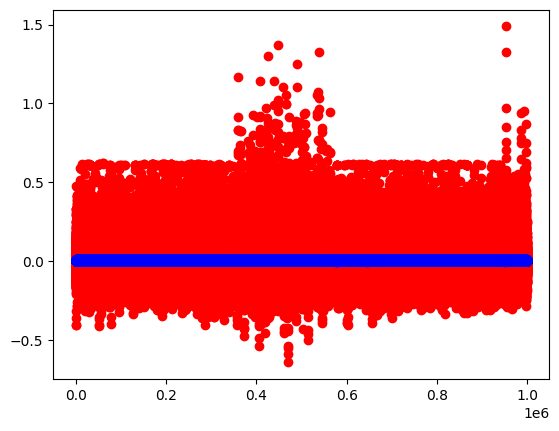

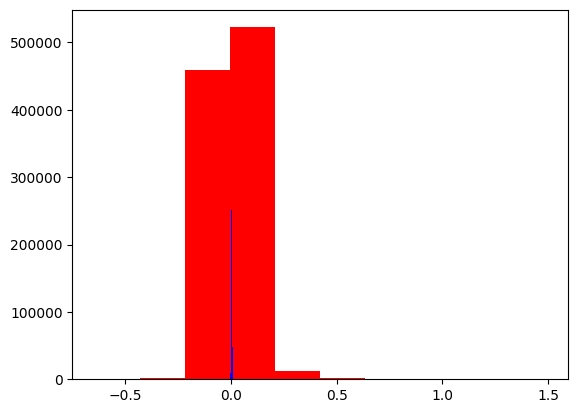

85


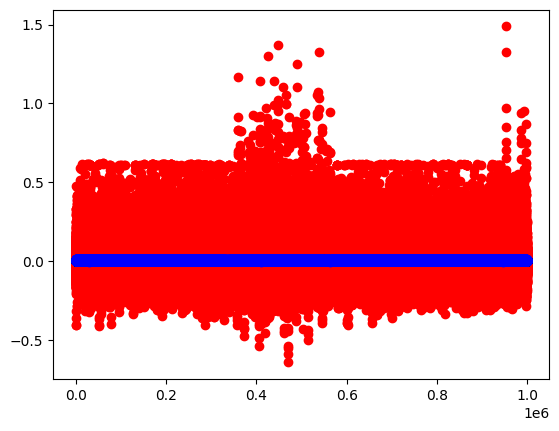

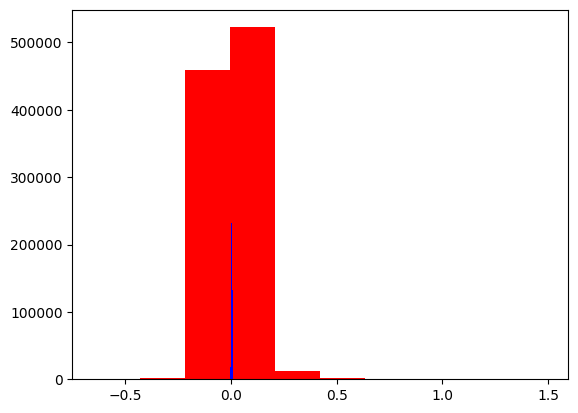

86


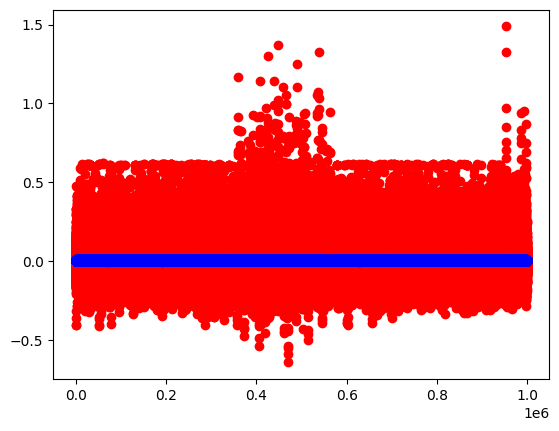

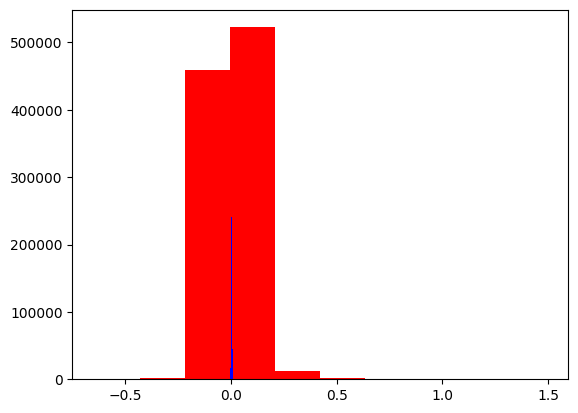

87


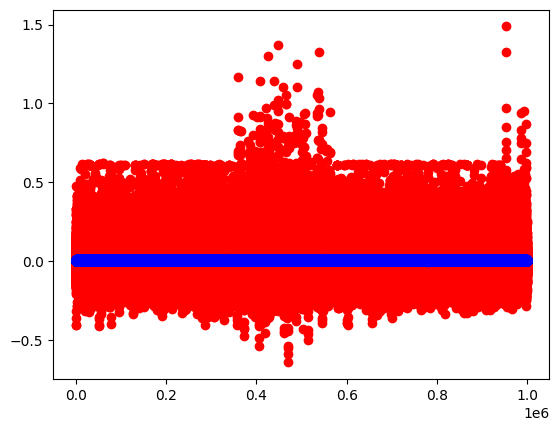

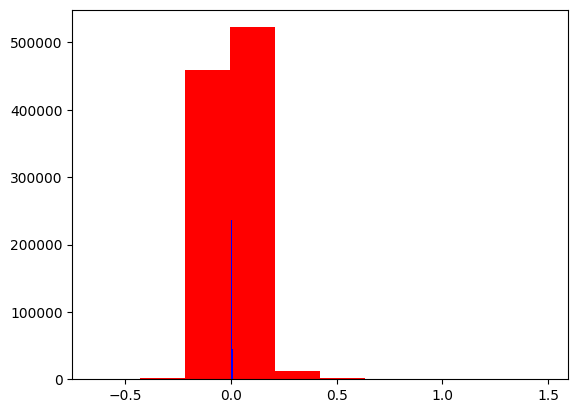

88


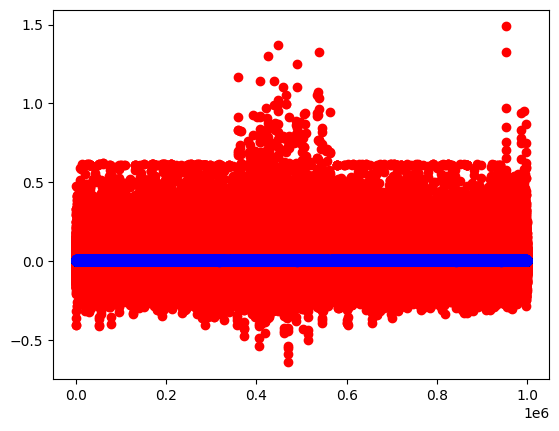

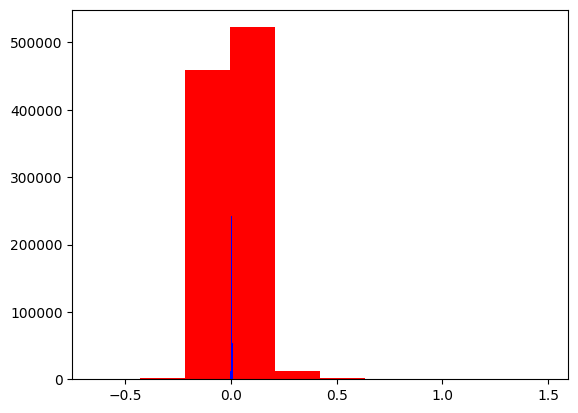

89


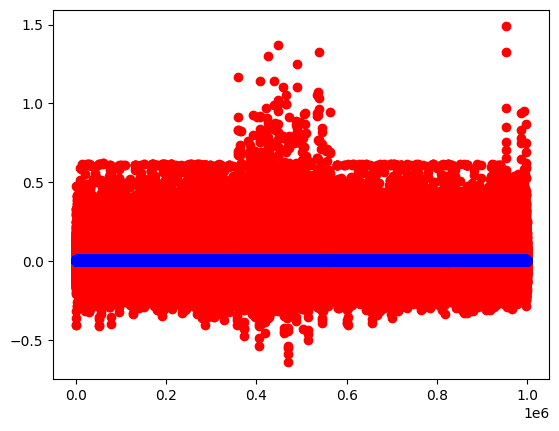

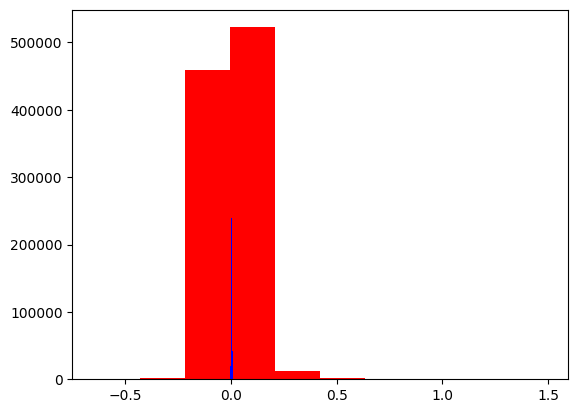

90


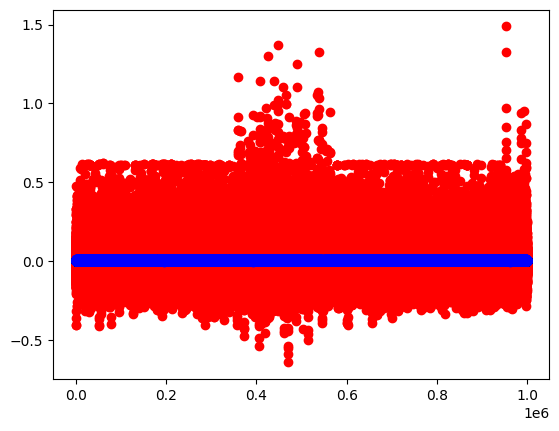

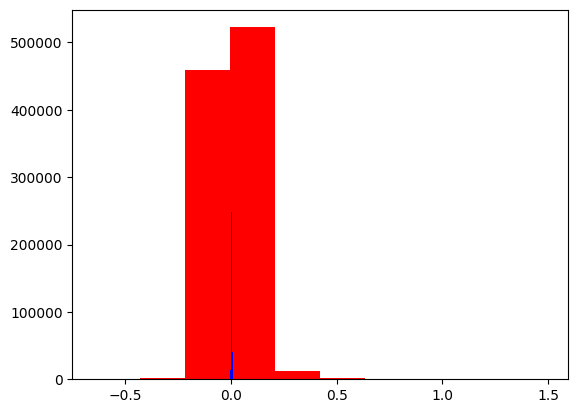

91


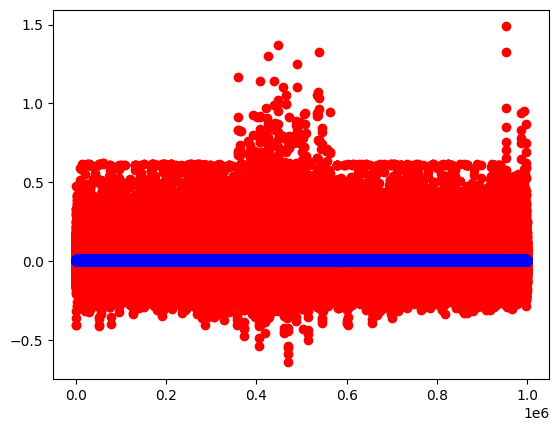

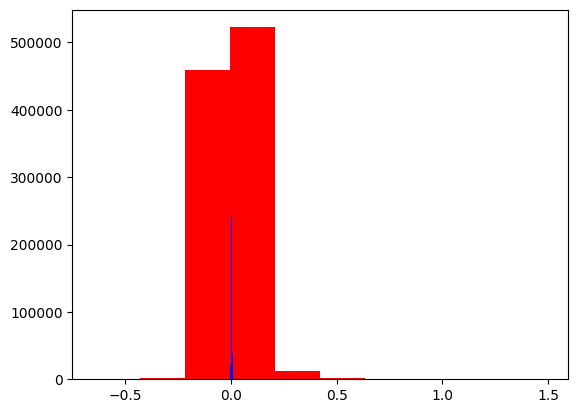

92


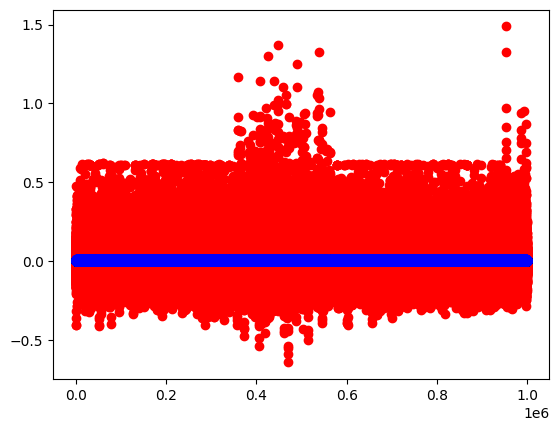

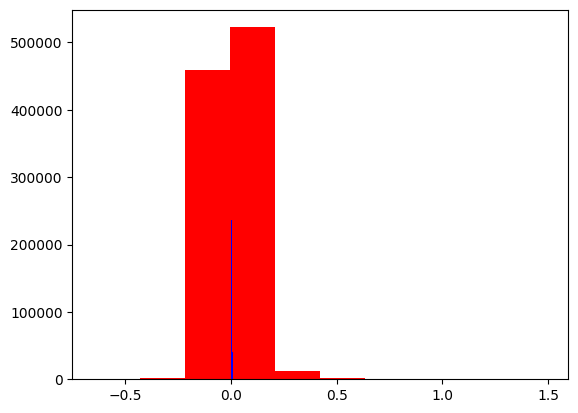

93


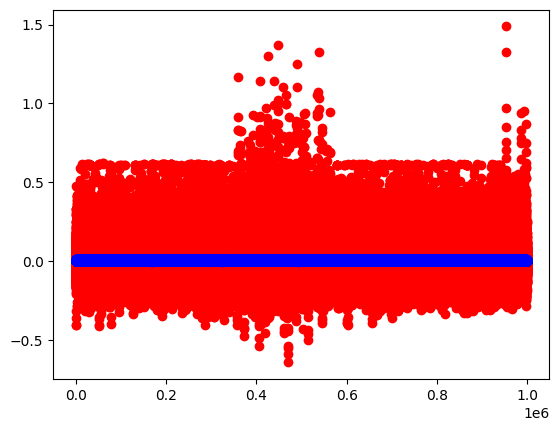

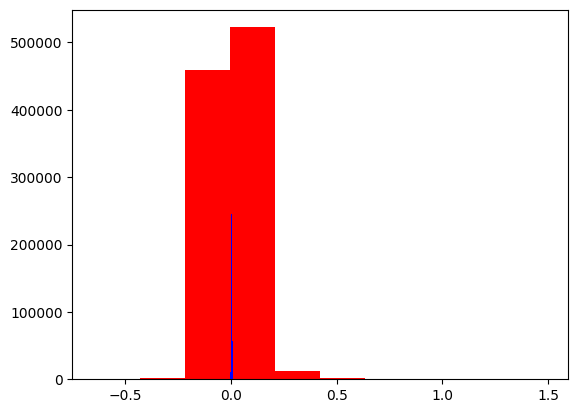

94


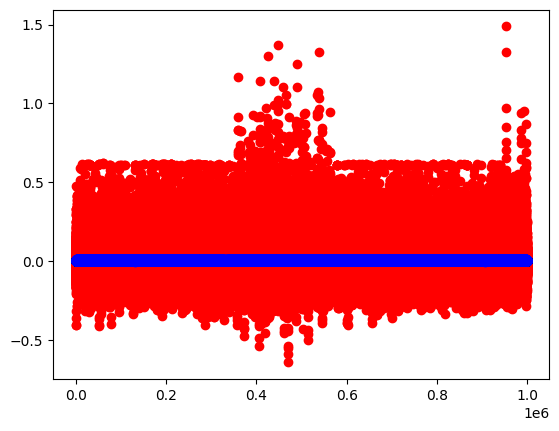

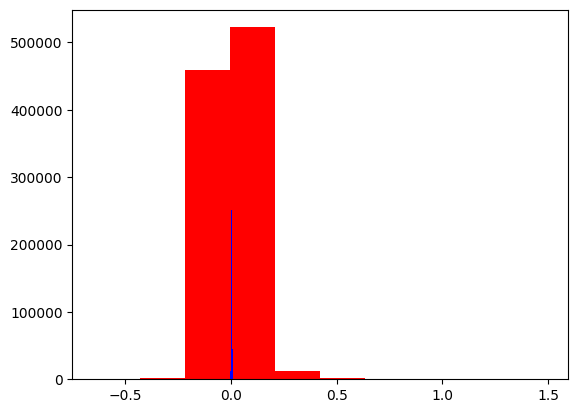

95


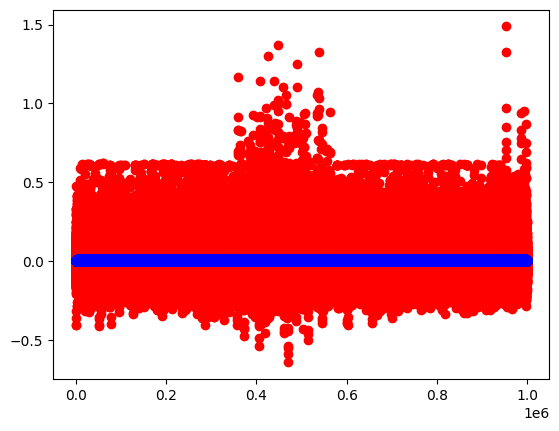

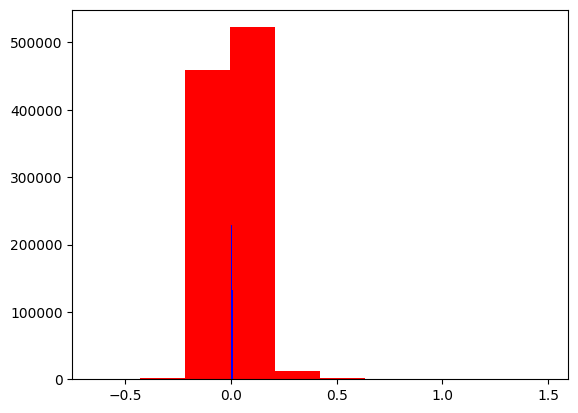

96


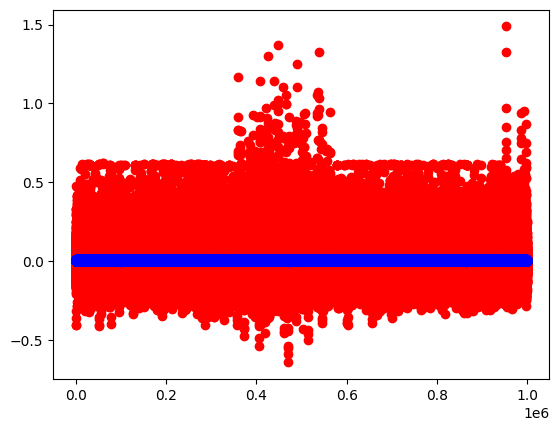

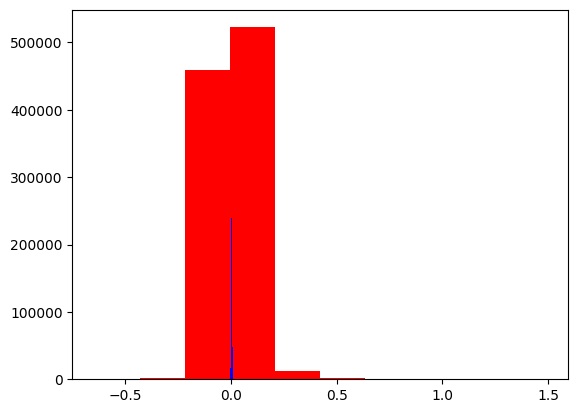

97


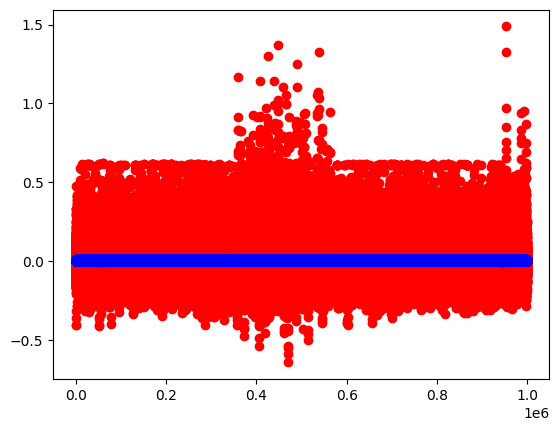

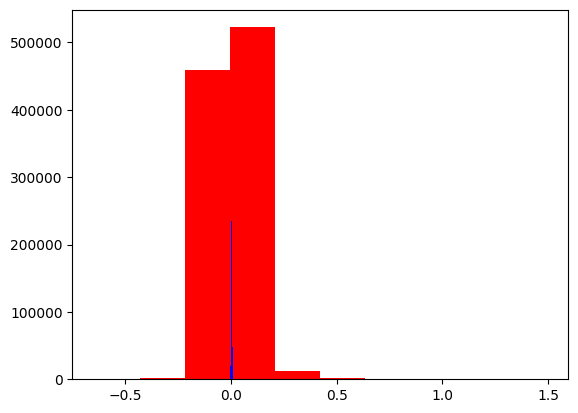

98


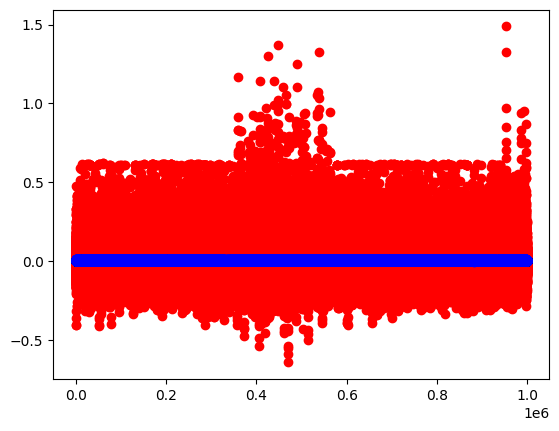

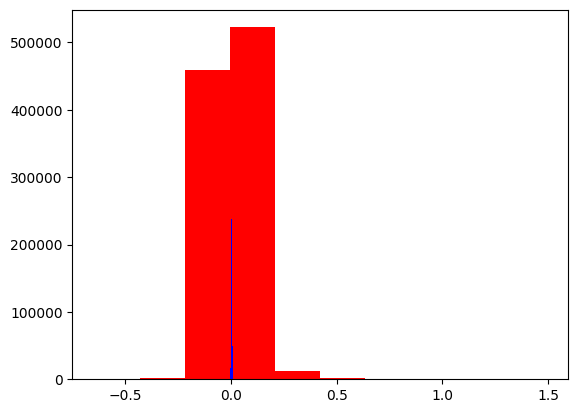

99


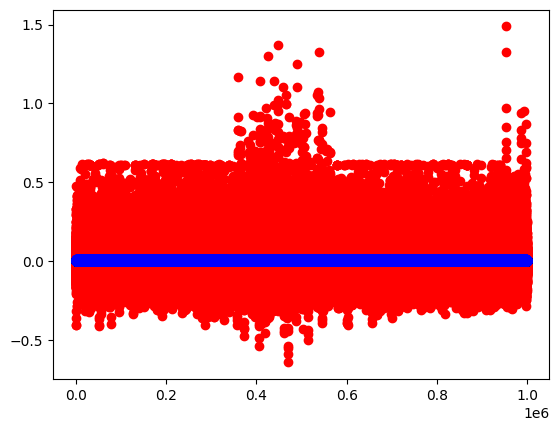

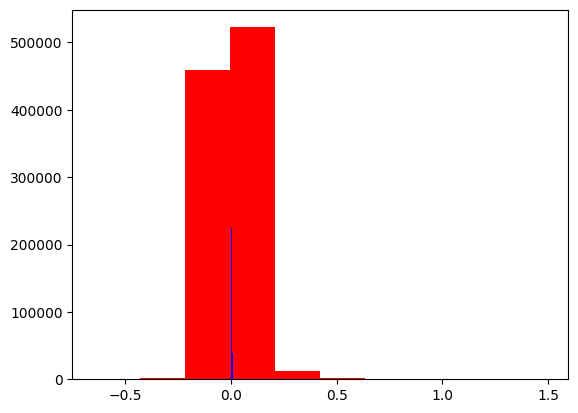

In [23]:
minks=9999
timer = Timer()
for epoch in range(100):
    train_loss=0
    train_num=0
    print(epoch)
    for step,(b_x,b_y) in enumerate(train_loader):
        b_x=b_x.cuda()
        b_y=b_y.cuda()
        output=rg(b_x)
        loss=loss_func(output,b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()*b_x.size(0)
        train_num+=b_x.size(0)
    scheduler.step()
    train_loss_all.append(train_loss/train_num)
    testy=rg(test_xt)
    testy=testy.cpu()
    mae=mean_absolute_error(test_yt.detach().numpy(),testy.detach().numpy())
    df=pd.DataFrame()
    df['real']=test_yt
    df['pre']=testy.detach().numpy()
    idx=scipy.stats.ks_2samp(df['pre'],df['real'])
    ks=scipy.stats.ks_2samp(df['pre'],df['real'])[0]
    torch.save(rg,'J:/quant_trade/modelbase/'+str(epoch)+'.pt')
    plt.scatter(y=df['real'],x=range(df.shape[0]),color='red')
    plt.scatter(y=df['pre'],x=range(df.shape[0]),color='blue')
    plt.show()
    plt.close()
    plt.hist(df['real'],color='red')
    plt.hist(df['pre'],color='blue')
    plt.show()
    plt.close()
    info.append([str(epoch),train_loss/train_num,mae,timer.stop(),ks,idx])
    pd.DataFrame(info).to_html('data.html')

In [17]:
df.describe()

,real,pre
count,998429.000000,998429.000000
mean,0.005368,0.003051
std,0.070115,0.001967
min,-0.500000,-0.002466
25%,-0.032663,0.001502
50%,0.000000,0.003001
75%,0.035000,0.004491
max,0.500000,0.009326
